## **Evolution beats random chance: Performance-dependent networ evolution for enhanced computational capacity.<br> M. Yadav, S. Sinha and M. Stender. arXiv**: https://arxiv.org/abs/2403.15869

## -> Following figures can be plotted from this notebook: <br>  Fig.2, Fig.3 (a), (d) and (g), Fig.5


## -> Plotting figures from data of following net. models: 
- Erdos Renyi Random Nets. -> **N0**
- Pefomormance Independent. Net. growth -> **N1**
- Pefomormance Dep. Net. growth -> **N2**
- Pefomormance Dep. Net. Evo (PDNE) -> **N3**
 

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot
from matplotlib.ticker import ScalarFormatter

import networkx as nx
import time
from tqdm.notebook import tqdm, trange
import os
import pandas as pd
import seaborn as sns
from numba import jit, cuda
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# 1. Import Network Evolution Data

In [3]:
def Last_NR_Finder(NR):
    NRs=[]
    for i in range(len(NR)):
        j=-1
        while True:
            if np.isfinite(np.asarray(NR[i]).T[1][j])==True:
                NRs.append(np.asarray(NR[i]).T[1][j])
                break
            else:
                j=j-1
    return np.asarray(NRs)

def LoadData(SaveDir, Task, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(Task,\
                                P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Task, P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'NARMA{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Task, P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'NARMA{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Task, P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_ER(SaveDir, Task, P_inp, P_out, ModelRep):
    
    NetMsrs_Reps=np.load(os.path.join(SaveDir,'NARMA{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep))) 
    Scores_Reps=np.load(os.path.join(SaveDir,'NARMA{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.npy'\
                                           .format(Task, P_inp, P_out, ModelRep)))  
    if Task[0]==10 or Task[0]==15:
        Graphs_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_Graphs_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
        InpsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_InpsNodes_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
        OutsNodes_Reps=nx.read_gpickle(os.path.join(SaveDir,'ER_OutsNodes_N10_N15_Pinp{:.2f}_Pout{:.2f}_Reps{:d}.gpickle'\
                                               .format(P_inp, P_out, ModelRep)))  
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return NetMsrs_Reps, NetMsrs_Names, Scores_Reps, Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_SinCos(SaveDir, Pars, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(Pars[0],\
                                Pars[1], Pars[2], Pars[3], P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'SinCos_NodeDel{:d}_a{:}_b{:}_p{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(Pars[0], Pars[1], Pars[2], Pars[3], P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def LoadData_ChaosVP(SaveDir, TaskType, P_inp, P_out, ModelRep):
    NetMsrs_tst=np.load(os.path.join(SaveDir,'{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'.format(TaskType,\
                                P_inp, P_out, 0))) 
    NetMsrs_Reps=[]; Scores_Reps=[]; Graphs_Reps=[]
    InpsNodes_Reps=[]; OutsNodes_Reps=[]
    for r in range(ModelRep):
        NetMsrs_Reps.append(np.load(os.path.join(SaveDir,'{:}_NetMeasures_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(TaskType, P_inp, P_out, r))) )
        Scores_Reps.append(np.load(os.path.join(SaveDir,'{:}_Scores_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.npy'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        Graphs_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_Graphs_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        InpsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_InpsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
        OutsNodes_Reps.append(nx.read_gpickle(os.path.join(SaveDir,'{:}_OutsNodes_Pinp{:.2f}_Pout{:.2f}_Rp{:d}.gpickle'\
                                               .format(TaskType, P_inp, P_out, r))) ) 
    NetMsrs_Names = np.load(os.path.join(SaveDir,'NetMeasures_Names.npy'))
    return np.asarray(NetMsrs_Reps), NetMsrs_Names, np.asarray(Scores_Reps), Graphs_Reps, InpsNodes_Reps, OutsNodes_Reps

def FirstZeroLocFinder(NetMsrs):
    ZerosLoc = np.where(NetMsrs==0)[0]
    if len(ZerosLoc)>=1:
        ZerosLocFirst=ZerosLoc[0]
    else:
        ZerosLocFirst=-1
    return ZerosLocFirst
            
def Plot_NetMsrs(TaskType, NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG, NetMsrs_Names, Colr, Lims00, PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 15; fig_size[1] = 9.25
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(2, 3, dpi=150)
    for r in range(0,NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,k])
        ##########################################
        for i in range(2):
            for j in range(3):               
                ax[i, j].plot(NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=0.25,c=Colr[0],alpha=0.5)
                ax[i, j].plot(NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=0.25,c=Colr[1],alpha=0.5) 
                ax[i, j].plot(NetMsrsC[r,:ZerosLocFirstC,k], zorder=-1, lw=0.25,c=Colr[2],alpha=0.5)
                ax[i, j].plot(NetMsrsF[r,:ZerosLocFirstF,k], zorder=-1, lw=0.25,c=Colr[5],alpha=0.5)
                ax[i, j].plot(NetMsrsG[r,:ZerosLocFirstG,k], zorder=-1, lw=0.25,c=Colr[6],alpha=0.5)
                                
                ax[i, j].scatter(len(NetMsrsA[r,:ZerosLocFirstA,k]), NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='P', s=100, c=Colr[0])
                ax[i, j].scatter(len(NetMsrsB[r,:ZerosLocFirstB,k]), NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=40, c=Colr[1])
                ax[i, j].scatter(len(NetMsrsC[r,:ZerosLocFirstC,k]), NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=80, c=Colr[2])
                ax[i, j].scatter(len(NetMsrsF[r,:ZerosLocFirstF,k]), NetMsrsF[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=50, c=Colr[5])
                ax[i, j].scatter(len(NetMsrsG[r,:ZerosLocFirstG,k]), NetMsrsG[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=60, c=Colr[6])
                
                ax[i, j].set_ylabel(NetMsrs_Names[k], fontsize=18)
                ax[i,j].set_xlim(0,510)
                ax[i,j].set_xlabel('Iteration', fontsize=18)
                ax[i,j].tick_params(axis='both',labelsize=15)
                ax[0,0].set_xscale('symlog')
                k+=1   
    for r in range(0,NetMsrsA.shape[0],2):#NetMsrsC.shape[0]):
    # for r in range(NetMsrsC.shape[0]):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,k])
        ##########################################
        for i in range(2):
            for j in range(3):                 
                ax[i, j].plot(NetMsrsD[r,:ZerosLocFirstD,k], zorder=-1, lw=0.25,c=Colr[3],alpha=0.5)
                ax[i, j].plot(NetMsrsE[r,:ZerosLocFirstE,k], zorder=-1, lw=0.25,c=Colr[4],alpha=0.5)
                
                ax[i, j].scatter(len(NetMsrsD[r,:ZerosLocFirstD,k]), NetMsrsD[r,ZerosLocFirstD-1,k],zorder=1, marker='D', s=50, c=Colr[3])
                ax[i, j].scatter(len(NetMsrsE[r,:ZerosLocFirstE,k]), NetMsrsE[r,ZerosLocFirstE-1,k],zorder=1, marker='s', s=30, c=Colr[4])
                
                ax[i, j].set_ylabel(NetMsrs_Names[k], fontsize=18)
                ax[i,j].set_xlim(0,510)
                ax[i,j].set_xlabel('Iteration', fontsize=18)
                ax[i,j].tick_params(axis='both',labelsize=15)
                ax[0,0].set_xscale('symlog')
                k+=1   
    
    ax[0,0].scatter(10000, 10000, marker='P', c=Colr[0], label='{:}'.format(TaskType[0]))
    ax[0,0].scatter(10000, 10000, marker='o', c=Colr[1], label='{:}'.format(TaskType[1])) 
    ax[0,0].scatter(10000, 10000, marker='*', c=Colr[2],s=150, label='{:}'.format(TaskType[2])) 
    ax[0,0].scatter(10000, 10000, marker='D', c=Colr[3], label='{:}'.format(TaskType[3]))
    ax[0,0].scatter(10000, 10000, marker='s', c=Colr[4], label='{:}'.format(TaskType[4]))
    ax[0,0].scatter(10000, 10000, marker='^', c=Colr[5], label='{:}'.format(TaskType[5]))
    ax[0,0].scatter(10000, 10000, marker='X', c=Colr[6],s=50, label='{:}'.format(TaskType[6]))
    ax[0,0].legend(fontsize=12, loc='upper left') 
    ax[0,1].set_ylim(0,0.8)
    ax[0,0].set_xlim(Lims00[0])
    ax[0,0].set_ylim(Lims00[1])
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig1_c.svg'), bbox_inches='tight')
    plt.show()
    
@jit(target_backend='cuda')
def Net_Plot(G,gs):    
    pos=nx.kamada_kawai_layout(G)
    labels = {}
    for idx, node in enumerate(G.nodes()):
        labels[node] = idx

    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = gs; fig_size[1] = gs
    fig, ax = plt.subplots(1, 1, dpi=150)
    plt.rcParams["figure.figsize"] = fig_size  
    plt.title('')

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='red', alpha=0.4)
    nx.draw_networkx_edges(G, pos, width=0.35)
    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    plt.box(False)
    plt.show()

In [4]:
P_inp=0.5; P_out=0.5
Model_Reps=10

#############Model M3 NARMA#############################################################
SaveDir3 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/NARMA/'
NetMsrsN3_NARMA5_Reps, NetMsrsV3_Names, ScoresN3_NARMA5_Reps, GraphsN3_NARMA5_Reps, InpsNodesN3_NARMA5_Reps,\
OutsNodesN3_NARMA5_Reps = LoadData(SaveDir3, [5], P_inp, P_out, Model_Reps)

NetMsrsN3_NARMA10_Reps, NetMsrsV3_Names, ScoresN3_NARMA10_Reps, GraphsN3_NARMA10_Reps, InpsNodesN3_NARMA10_Reps,\
OutsNodesN3_NARMA10_Reps = LoadData(SaveDir3, [10], P_inp, P_out, Model_Reps)

NetMsrsN3_NARMA15_Reps, NetMsrsV3_Names, ScoresN3_NARMA15_Reps, GraphsN3_NARMA15_Reps, InpsNodesN3_NARMA15_Reps,\
OutsNodesN3_NARMA15_Reps = LoadData(SaveDir3, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN3_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_NARMA10_Reps.shape,\
      len(InpsNodesN3_NARMA10_Reps[1]), len(GraphsN3_NARMA10_Reps[1]))

#############Model M0 NARMA#############################################################
SaveDir30 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/ERNets/NARMA/'
Model_Reps=500

NetMsrsN0_NARMA10_Reps, NetMsrsV3_Names, ScoresN0_NARMA10_Reps, GraphsN0_NARMA10_Reps, InpsNodesN0_NARMA10_Reps,\
OutsNodesN0_NARMA10_Reps = LoadData_ER(SaveDir30, [10], P_inp, P_out, Model_Reps)

NetMsrsN0_NARMA15_Reps, NetMsrsV3_Names, ScoresN0_NARMA15_Reps, GraphsN0_NARMA15_Reps, InpsNodesN0_NARMA15_Reps,\
OutsNodesN0_NARMA15_Reps = LoadData_ER(SaveDir30, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN3_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_NARMA10_Reps.shape,\
      len(InpsNodesN3_NARMA10_Reps[1]), len(GraphsN3_NARMA10_Reps[1]))

#############Model M1 NARMA#############################################################
SaveDir31 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/NARMA/'
Model_Reps=10
NetMsrsN1_NARMA5_Reps, NetMsrsV3_Names, ScoresN1_NARMA5_Reps, GraphsN1_NARMA5_Reps, InpsNodesN1_NARMA5_Reps,\
OutsNodesN1_NARMA5_Reps = LoadData(SaveDir31, [5], P_inp, P_out, Model_Reps)

NetMsrsN1_NARMA10_Reps, NetMsrsV3_Names, ScoresN1_NARMA10_Reps, GraphsN1_NARMA10_Reps, InpsNodesN1_NARMA10_Reps,\
OutsNodesN1_NARMA10_Reps = LoadData(SaveDir31, [10], P_inp, P_out, Model_Reps)

NetMsrsN1_NARMA15_Reps, NetMsrsV3_Names, ScoresN1_NARMA15_Reps, GraphsN1_NARMA15_Reps, InpsNodesN1_NARMA15_Reps,\
OutsNodesN1_NARMA15_Reps = LoadData(SaveDir31, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN1_NARMA15_Reps.shape, NetMsrsV3_Names, '\n', ScoresN1_NARMA15_Reps.shape,\
      len(InpsNodesN1_NARMA15_Reps[1]), len(GraphsN3_NARMA15_Reps[1]))

#############Model M2 NARMA#############################################################
SaveDir32 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/NARMA/'
NetMsrsN2_NARMA5_Reps, NetMsrsV3_Names, ScoresN2_NARMA5_Reps, GraphsN2_NARMA5_Reps, InpsNodesN2_NARMA5_Reps,\
OutsNodesN2_NARMA5_Reps = LoadData(SaveDir32, [5], P_inp, P_out, Model_Reps)

NetMsrsN2_NARMA10_Reps, NetMsrsV3_Names, ScoresN2_NARMA10_Reps, GraphsN2_NARMA10_Reps, InpsNodesN2_NARMA10_Reps,\
OutsNodesN2_NARMA10_Reps = LoadData(SaveDir32, [10], P_inp, P_out, Model_Reps)

NetMsrsN2_NARMA15_Reps, NetMsrsV3_Names, ScoresN2_NARMA15_Reps, GraphsN2_NARMA15_Reps, InpsNodesN2_NARMA15_Reps,\
OutsNodesN2_NARMA15_Reps = LoadData(SaveDir32, [15], P_inp, P_out, Model_Reps)

print(NetMsrsN2_NARMA10_Reps.shape, NetMsrsV3_Names, '\n', ScoresN2_NARMA15_Reps.shape,\
      len(InpsNodesN2_NARMA15_Reps[1]), len(GraphsN2_NARMA10_Reps[1]))

#############Model M3 SinCos#############################################################
SaveDir4 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/SinCos/'
SaveDir41 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/SinCos/'
SaveDir42 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/SinCos/'
SaveDir4E = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/SinCos/ER_Init/'
Model_Reps=10
Pars1=[50, [0], [1], [1]]
Pars2=[50, [1], [0.25], [3]]

NetMsrsN3_SinCos1_Reps, NetMsrsV3_Names, ScoresN3_SinCos1_Reps, GraphsN3_SinCos1_Reps, InpsNodesN3_SinCos1_Reps,\
OutsNodesN3_SinCos1_Reps = LoadData_SinCos(SaveDir4, Pars1, P_inp, P_out, Model_Reps)

NetMsrsN1_SinCos1_Reps, NetMsrsV3_Names, ScoresN1_SinCos1_Reps, GraphsN1_SinCos1_Reps, InpsNodesN1_SinCos1_Reps,\
OutsNodesN1_SinCos1_Reps = LoadData_SinCos(SaveDir41, Pars1, P_inp, P_out, Model_Reps)
NetMsrsN2_SinCos1_Reps, NetMsrsV3_Names, ScoresN2_SinCos1_Reps, GraphsN2SinCos1_Reps, InpsNodesN2_SinCos1_Reps,\
OutsNodesN2_SinCos1_Reps = LoadData_SinCos(SaveDir42, Pars1, P_inp, P_out, Model_Reps)


NetMsrsN3_SinCos2_Reps, NetMsrsV3_Names, ScoresN3_SinCos2_Reps, GraphsN3_SinCos2_Reps, InpsNodesN3_SinCos2_Reps,\
OutsNodesN3_SinCos2_Reps = LoadData_SinCos(SaveDir4, Pars2, P_inp, P_out, Model_Reps)

NetMsrsN1_SinCos2_Reps, NetMsrsV3_Names, ScoresN1_SinCos2_Reps, GraphsN1_SinCos2_Reps, InpsNodesN1_SinCos2_Reps,\
OutsNodesN1_SinCos2_Reps = LoadData_SinCos(SaveDir41, Pars2, P_inp, P_out, Model_Reps)
NetMsrsN2_SinCos2_Reps, NetMsrsV3_Names, ScoresN2_SinCos2_Reps, GraphsN2_SinCos2_Reps, InpsNodesN2_SinCos2_Reps,\
OutsNodesN2_SinCos2_Reps = LoadData_SinCos(SaveDir42, Pars2, P_inp, P_out, Model_Reps)


print(NetMsrsN3_SinCos1_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_SinCos1_Reps.shape,\
      len(InpsNodesN3_SinCos1_Reps[1]), len(GraphsN3_SinCos1_Reps[1]))

#############Model M3 Chaos#############################################################
SaveDir5 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/Chaos/'
SaveDir51 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/Chaos/'
SaveDir52 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/Chaos/'

Model_Reps=10
NetMsrsN3_Chaos_Reps, NetMsrsV3_Names, ScoresN3_Chaos_Reps, GraphsN3_Chaos_Reps, InpsNodesN3_Chaos_Reps,\
OutsNodesN3_Chaos_Reps = LoadData_ChaosVP(SaveDir5, 'Chaos', P_inp, P_out, Model_Reps)
NetMsrsN1_Chaos_Reps, NetMsrsV3_Names, ScoresN1_Chaos_Reps, GraphsN1_Chaos_Reps, InpsNodesN1_Chaos_Reps,\
OutsNodesN1_Chaos_Reps = LoadData_ChaosVP(SaveDir51, 'Chaos', P_inp, P_out, Model_Reps)
NetMsrsN2_Chaos_Reps, NetMsrsV3_Names, ScoresN2_Chaos_Reps, GraphsN2_Chaos_Reps, InpsNodesN2_Chaos_Reps,\
OutsNodesN2_Chaos_Reps = LoadData_ChaosVP(SaveDir52, 'Chaos', P_inp, P_out, Model_Reps)

#############Model M3 VDP#############################################################
SaveDir6 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N3/VDP/'
SaveDir61 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N1/VDP/'
SaveDir62 = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/1.NetGrowth_Models/Data/Checkpoint-Model_V3/1Task/N2/VDP/'

Model_Reps=10
NetMsrsN3_VDP_Reps, NetMsrsV3_Names, ScoresN3_VDP_Reps, GraphsN3_VDP_Reps, InpsNodesN3_VDP_Reps,\
OutsNodesN3_VDP_Reps = LoadData_ChaosVP(SaveDir6, 'VDP', P_inp, P_out, Model_Reps)
NetMsrsN1_VDP_Reps, NetMsrsV3_Names, ScoresN1_VDP_Reps, GraphsN1_VDP_Reps, InpsNodesN1_VDP_Reps,\
OutsNodesN1_VDP_Reps = LoadData_ChaosVP(SaveDir61, 'VDP', P_inp, P_out, Model_Reps)
NetMsrsN2_VDP_Reps, NetMsrsV3_Names, ScoresN2_VDP_Reps, GraphsN2_VDP_Reps, InpsNodesN2_VDP_Reps,\
OutsNodesN2_VDP_Reps = LoadData_ChaosVP(SaveDir62, 'VDP', P_inp, P_out, Model_Reps)

print(NetMsrsN3_Chaos_Reps.shape, NetMsrsV3_Names, '\n', ScoresN3_Chaos_Reps.shape,\
      len(InpsNodesN3_Chaos_Reps[1]), len(GraphsN3_Chaos_Reps[1]))

(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 274 275
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 274 275
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 500 501
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 500 230
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 1) 10 11
(10, 510, 6) ['Nodes' 'Avg. CC' 'Avg. In_Deg' 'Avg. Out_Deg' 'Communities' 'Density'] 
 (10, 2, 510, 2, 3) 24 25


## 1.1. Network visualization at different growth/evolutionary stage

25


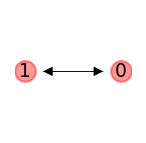

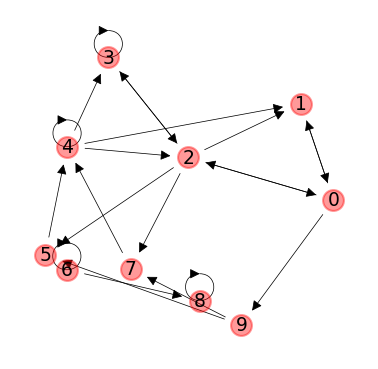

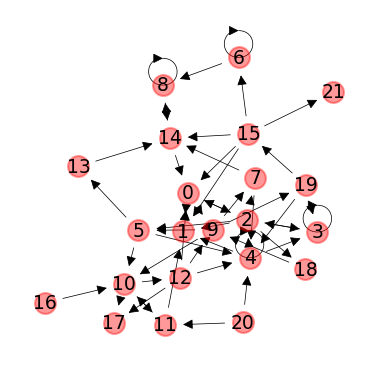

In [6]:
i=1
print(len(GraphsN3_Chaos_Reps[i]))

Net_Plot(GraphsN3_Chaos_Reps[i][0],1)
Net_Plot(GraphsN3_Chaos_Reps[i][8],3)
Net_Plot(GraphsN3_Chaos_Reps[i][-1],3)

17


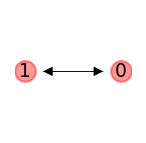

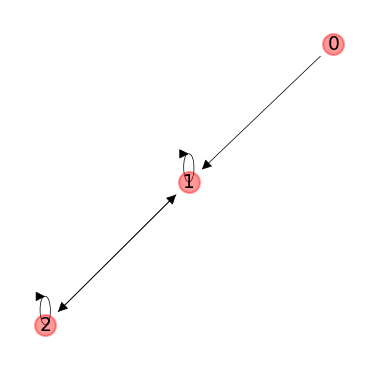

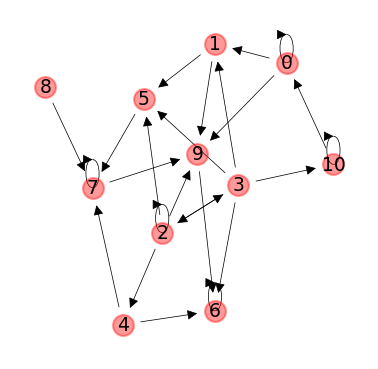

In [7]:
i=0
print(len(GraphsN3_SinCos2_Reps[i]))

Net_Plot(GraphsN3_SinCos2_Reps[i][0],1)
Net_Plot(GraphsN3_SinCos2_Reps[i][3],3)
Net_Plot(GraphsN3_SinCos2_Reps[i][-1],3)

## 1.2. Time Series plots from final evolved networks

In [8]:
# @jit(target_backend='cuda')   
def Ridge_Regression(R, beta, V_train, N_O, OutsNodes):
    W_outs = [[]]*N_O 
    for i in range(N_O):
        R_out = R[OutsNodes[i],:]
        W_outs[i] = np.dot(np.dot(V_train[i], R_out.T), np.linalg.inv((np.dot(R_out, R_out.T) + beta*np.identity(R_out.shape[0]))))
    return W_outs

# @jit(target_backend='cuda')
def MSE(A, B):
    return np.mean(((A - B)**2))

# @jit(target_backend='cuda')
def Errors(y_predicted, y_actual):
    MSE = np.mean(np.square(np.subtract(y_predicted,y_actual)))
    Variance = (np.mean(np.square(np.subtract(y_actual, np.mean(y_actual) ) ) ) )
    NMSE = MSE/Variance
    NRMSE = np.sqrt(NMSE)
    return NMSE, NRMSE 

### Testing
@jit(target_backend='cuda')   
def Test_or_Predict(GNet, Init, Inps_t, Winps, N, N_I, N_O, OutsNodes, alpha, W_outs, Outs, Trans):
    Res_t = Reservoir(GNet, Init, Inps_t, Winps, N_I, N, alpha)
    
    Outs_pred=[[]]*N_O
    NMSEs_t=np.zeros(N_O)
    for i in range(N_O):
        Outs_pred[i] = np.dot(W_outs[i], Res_t[OutsNodes[i],Trans:])
        NMSEs_t[i] = Errors(Outs_pred[i], Outs[i,Trans:])[0] 
    return Outs_pred, NMSEs_t

def NARMA_MemoryX(inp, Memory):
    y = np.zeros(inp.shape[0])
    y[0] = inp[0]
    for i in range(inp.shape[0]-1):
        sumy = 0
        for j in range(1, Memory+1):
            if i>j: 
                sumy += y[i+1-j]
        
        if Memory>10:
            y[i+1] = np.tanh(0.3*y[i] + 0.05*y[i]*sumy + 1.5*inp[i]*inp[i+1-Memory] + 0.1)
        else:
            y[i+1] = 0.3*y[i] + 0.05*y[i]*sumy + 1.5*inp[i]*inp[i+1-Memory] + 0.1
    return y

def NARMA_Call(N_I, Npts_U, NARMA_Props):
    InpDistrib = NARMA_Props[0]; MemoryX = NARMA_Props[1]
    
    Inps=np.zeros((N_I, Npts_U)); Outs=np.zeros((N_I, Npts_U))
    Inps_test=np.zeros((N_I, Npts_U)); Outs_test=np.zeros((N_I, Npts_U))
    
    for i in range(N_I):  
        Inps[i] = np.random.uniform(InpDistrib[i,0], InpDistrib[i,1], Npts_U) 
        Outs[i] = NARMA_MemoryX(Inps[i], MemoryX[i])

        Inps_test[i] = np.random.uniform(InpDistrib[i,0], InpDistrib[i,1], Npts_U) 
        Outs_test[i] = NARMA_MemoryX(Inps_test[i], MemoryX[i])
    return Inps, Outs, Inps_test, Outs_test


def SinCos_Inp(Npts_U, h, omega, phi, a_sc, b_sc, P_sc):
    t = np.arange(0, int(Npts_U*h), h)
    #####Input##################
    U = np.sin(omega*t + phi)
    #####Output##################
    Y = a_sc*np.sin(omega*t + phi)**P_sc + b_sc*np.cos(omega*t + phi)**P_sc
    return U, Y
    
def SinCos_Call(N_I, Npts_U, SinCos_Props):
    h=SinCos_Props[0]; Omegas=SinCos_Props[1]; Phis=SinCos_Props[2]
    A_scs=SinCos_Props[3]; B_scs=SinCos_Props[4]; P_scs=SinCos_Props[5] 

    Inps=np.zeros((N_I, Npts_U)); Outs=np.zeros((N_I, Npts_U))
    Inps_test=np.zeros((N_I, Npts_U)); Outs_test=np.zeros((N_I, Npts_U))
    
    for i in range(N_I):  
        Inps[i], Outs[i] = SinCos_Inp(Npts_U, h, Omegas[i], Phis[i], A_scs[i], B_scs[i], P_scs[i])
        Inps_test[i], Outs_test[i] = SinCos_Inp(Npts_U, h, Omegas[i], 2, A_scs[i], B_scs[i], P_scs[i])
    return Inps, Outs, Inps_test, Outs_test

def Lorenz(t, X, s=10, r=28, b=3.0):     
    x, y, z = X
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

def SolveLorenz(Npts_U):
    # numerical time integration
    h=0.02
    T = int(Npts_U*h)
    t_eval = np.arange(start=0, stop=T, step=h)
    
    X0_a=[-10,0,0.5]
    Sol_a = solve_ivp(Lorenz, t_span=[t_eval[0], t_eval[-1]], y0=X0_a, t_eval=t_eval, args=())
    Inps_a = np.array([Sol_a.y[0,:], Sol_a.y[1,:], Sol_a.y[2,:]])
    
    X0_b=[-5,1,-0.5]
    Sol_b = solve_ivp(Lorenz, t_span=[t_eval[0], t_eval[-1]], y0=X0_b, t_eval=t_eval, args=())
    Inps_b = np.array([Sol_b.y[0,:], Sol_b.y[1,:], Sol_b.y[2,:]])
    return Inps_a, Inps_a, Inps_b, Inps_b  

def VDP(t, X, mu=1):
    x, y = X
    return [y, mu*(1 - x**2)*y - x]

def SolveVDP(Npts_U):
    # numerical time integration
    h=0.1
    T = int(Npts_U*h)
    t_eval = np.arange(start=0, stop=T, step=h)
    
    X0_a=[1,-1]
    Sol_a = solve_ivp(VDP, t_span=[t_eval[0], t_eval[-1]], y0=X0_a, t_eval=t_eval, args=())
    Inps_a = np.array([Sol_a.y[0,:], Sol_a.y[1,:]])
    
    X0_b=[1,-1]
    Sol_b = solve_ivp(VDP, t_span=[t_eval[0], t_eval[-1]], y0=X0_b, t_eval=t_eval, args=())
    Inps_b = np.array([Sol_b.y[0,:], Sol_b.y[1,:]])
        
    return Inps_a, Inps_a, Inps_b, Inps_b

def InpGenerate(TaskType, N_I, Npts_U):    
    h=0.1
    if TaskType=="NARMA5":
        MemoryX = np.array([5]); InpDistrib=np.array([[0, 0.5], [0, 0.5]])
        InpProps = [InpDistrib, MemoryX]
        Inps, Outs, Inps_test, Outs_test = NARMA_Call(N_I, Npts_U, InpProps)
    if TaskType=="NARMA10":
        MemoryX = np.array([10]); InpDistrib=np.array([[0, 0.5], [0, 0.5]])
        InpProps = [InpDistrib, MemoryX]
        Inps, Outs, Inps_test, Outs_test = NARMA_Call(N_I, Npts_U, InpProps)
    if TaskType=="NARMA15":
        MemoryX = np.array([15]); InpDistrib=np.array([[0, 0.5], [0, 0.5]])
        InpProps = [InpDistrib, MemoryX]
        Inps, Outs, Inps_test, Outs_test = NARMA_Call(N_I, Npts_U, InpProps)
    if TaskType=="SinCos1":
        Omegas=np.array([1]); Phis=np.array([0]);
        A_scs=np.array([0]); B_scs=np.array([1]); P_scs=np.array([1])
        InpProps = [h, Omegas, Phis, A_scs, B_scs, P_scs]
        Inps, Outs, Inps_test, Outs_test = SinCos_Call(N_I, Npts_U, InpProps)
    if TaskType=="SinCos2":
        Omegas=np.array([1]); Phis=np.array([0]);
        A_scs=np.array([1]); B_scs=np.array([0.25]); P_scs=np.array([3])
        InpProps = [h, Omegas, Phis, A_scs, B_scs, P_scs]
        Inps, Outs, Inps_test, Outs_test = SinCos_Call(N_I, Npts_U, InpProps)
    if TaskType=="Chaos":
        Inps, Outs, Inps_test, Outs_test = SolveLorenz(Npts_U)
    if TaskType=="VDP":
        Inps, Outs, Inps_test, Outs_test = SolveVDP(Npts_U)
    
    return Inps, Outs, Inps_test, Outs_test

def InpPlot(Inps, Outs, N_I):
    for i in range(N_I):  
        fig_size = plt.rcParams["figure.figsize"]  
        fig_size[0] = 8; fig_size[1] = 1
        plt.rcParams["figure.figsize"] = fig_size 
        plt.plot(Inps[i, :200], c='C0')
        plt.show()
        plt.plot(Outs[i, :200], c='C1')
        plt.show()


In [9]:
# @jit(target_backend='cuda') 
def Reservoir(GNet, Init, Inps, Winps, N_I, N, alpha):
    Nodes_res = GNet.shape[0]; 
    Npts_U = Inps.shape[1]

    R = np.zeros([N, Npts_U])
    R[:,0] = Init
    
    #time loop
    for t in range(0, Npts_U-1):
        Inp_term=0
        for i in range(N_I):
            Inp_term +=  Winps[i]*Inps[i,t]
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T) + Inp_term )
    return R

def GNet_SpectralRadius(Gn, Spectral_radius):
    ### Rescaling to a desired spectral radius 
    Spectral_radius_Gn = max(abs(np.linalg.eigvals(Gn)))
    ResMat = Gn*Spectral_radius/Spectral_radius_Gn
    return ResMat

# @jit(target_backend='cuda')   
def RC(G, Spectral_radius, N_I, N_O, InpsNodes, OutsNodes, Inps, Outs, Inps_test, Outs_test, Trans, RC_reps, Return=0):
    Outs_predict=np.zeros((RC_reps, N_O, Outs_test[0,Trans:].shape[0]))
    Outs_test_pred=np.zeros((RC_reps, N_O, Outs_test[0,Trans:].shape[0]))
    MSEs_train=np.zeros((RC_reps, N_O)); MSEs_test_pred=np.zeros((RC_reps, N_O))
    for r in range(RC_reps):
        ### G to Matrix
        GNet = nx.to_numpy_matrix(G)
        N = G.number_of_nodes()

        GNet = GNet_SpectralRadius(GNet, Spectral_radius)

        #### Input Nodes
        Winps = np.zeros((N_I, N))
        for i in range(N_I):
            Winps[i, InpsNodes[i]] = 0.05  
        ### Reservoir run
        Init = np.random.random(N)*0.25
        alpha = 0.9 #0.09999999999

        Res = Reservoir(GNet, Init, Inps, Winps, N_I, N, alpha)

        ### Training
        beta = 5e-10 #5e-8 
        W_outs = Ridge_Regression(Res[:,Trans:], beta, Outs[:,Trans:], N_O, OutsNodes)
        ### Testing
        Outs_predict[r], MSEs_train[r] = Test_or_Predict(GNet, Init, Inps, Winps, N, N_I, N_O, OutsNodes, alpha, W_outs, Outs, Trans)
        
        ### Prediction
        Outs_test_pred[r], MSEs_test_pred[r] = Test_or_Predict(GNet, Init, Inps_test, Winps, N, N_I, N_O, OutsNodes, alpha, W_outs, Outs_test, Trans)
        
    ##### Mean over RC reps
    MSEs_MnSD_train = np.array([np.mean(MSEs_train, axis=0), np.std(MSEs_train, axis=0)])
    MSEs_MnSD_test_pred = np.array([np.mean(MSEs_test_pred, axis=0), np.std(MSEs_test_pred, axis=0)])
    
    if Return==0:
        return MSEs_MnSD_train, MSEs_MnSD_test_pred
    
    if Return==1:
        return Outs_predict, Outs_test_pred, MSEs_MnSD_train, MSEs_MnSD_test_pred

    
def Auto_Reservoir(GNet, Init, TaskType, Inps, Winps, Wouts, OutsNodes, N_I, N, alpha):
    Nodes_res = GNet.shape[0]; 
    Npts_U = Inps.shape[1]
    R = np.zeros([N, Npts_U])
    R[:,0] = Init
    Inps_pred = np.zeros([N_I, Npts_U])     
    #time loop
    for t in range(0, Npts_U-1):
        Inp_term=0
        # Inp_term = Winps[0]*Inps[0,t]
        #### Warmup phase###############################################
        if t<1500:
            for i in range(0,N_I):
                Inp_term +=  Winps[i]*Inps[i,t]
        if t>=1500:
            if TaskType=='VDP':
                Inp_term =  Winps[0]*Inps_pred[0,t]+(Winps[1]*Inps[1,t])
            if TaskType=='Chaos':
                for i in range(0,N_I):
                    Inp_term +=  Winps[i]*Inps_pred[i,t]
            
        #############################################################     
        R[:,t+1] = (1 - alpha)*np.asarray(R[:,t]) + alpha*np.tanh(np.dot(GNet, R[:,t].T)+ Inp_term )    
        
        ### Next step auto prediction
        for j in range(N_I):
            Inps_pred[j, t+1] = np.dot(Wouts[j], R[OutsNodes[j],t+1])                
    return R, Inps_pred

def Auto_RC(G, Spectral_radius, alpha, TaskType, N_I, N_O, InpsNodes, OutsNodes, Inps, Outs, Trans):
    ### G to Matrix
    GNet = nx.to_numpy_matrix(G)
    N = G.number_of_nodes()

    GNet = GNet_SpectralRadius(GNet, Spectral_radius)

    #### Input Nodes
    Winps = np.zeros((N_I, N))
    for i in range(N_I):
        Winps[i, InpsNodes[i]] = 0.01 
    # print('A2. In RC, Inp nodes:', InpsNodes, 'Winps:', Winps, 'N:', N)
    ### Reservoir run
    Init = np.random.random(N)*0.1
    Res = Reservoir(GNet, Init, Inps, Winps, N_I, N, alpha)

    ### Training
    beta = 5e-10 #5e-10 
    W_outs = Ridge_Regression(Res[:,Trans:], beta, Outs[:,Trans:], N_O, OutsNodes)

    Res, Inps_pred = Auto_Reservoir(GNet, Init, TaskType, Inps, Winps, W_outs, OutsNodes, N_I, N, alpha)
    return Inps_pred
        
    
def Plot_t(N_O, Outs, Outs_t, Trans, Tillt, MSE_t):
    for i in range(N_O):
        fig_size = plt.rcParams["figure.figsize"]  
        fig_size[0] = 8; fig_size[1] = 2.5
        plt.rcParams["figure.figsize"] = fig_size  

        plt.plot(Outs[i,Trans:Tillt+Trans], lw=0.75)
        plt.title('Error={:.10f}'.format(MSE_t[i]))
        plt.plot(Outs_t[i,:Tillt], lw=0.75)
        plt.show()
        
def PredictionsPlot(OutsO, OutsP, i, TaskNames, Colrs,Tplt, PlotDir, FigSize, Ylims, Save):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size = FigSize
    plt.rcParams["figure.figsize"] = fig_size 
    plt.rcParams['figure.dpi'] = 100
     
    plt.plot(OutsP[i], c=Colrs[i],lw=1.75, ls='--')
    plt.plot(OutsO[i][500:], c=Colrs[i],lw=1, label='{:}'.format(TaskNames[i]))
    # plt.legend(fontsize=14, loc='upper left') 
    plt.ylabel(TaskNames[i], fontsize=25)
    plt.xlim(0,Tplt)
    plt.ylim(Ylims)
    plt.xlabel('time', fontsize=25)
    plt.tick_params(axis='both',labelsize=20)
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_d{:d}.svg'.format(i)), bbox_inches='tight')
    plt.show()

In [11]:
N_I=1; N_O=1
Npts_U = 2500; Transs=500;

#### Scores_Names#################################################################
Scores_Names=['NMSE train', 'NMSE pred']

####Model params
Spectral_radius=1.1; RC_Reps=1

PlotDir = 'C:/Work/TU-Berlin/Projects/2.RC_DynamicNets/Manuscript/Figs/'

In [13]:
i=8;
Inps, Outs5, Inps_test, Outs5_test = InpGenerate('NARMA5', N_I, Npts_U)
Outs_pred5, Outs_test_pred_N5, MSEs_train, MSEs_pred = RC(GraphsN3_NARMA5_Reps[i][-1], Spectral_radius,\
            N_I, N_O, InpsNodesN3_NARMA5_Reps[i][-1], OutsNodesN3_NARMA5_Reps[i][-1],\
            Inps, Outs5, Inps_test, Outs5_test, Transs, RC_Reps, Return=1)
print(MSEs_pred)
# j=9; j2=7
j=9; j2=-1
Inps, Outs10, Inps_test, Outs10_test = InpGenerate('NARMA10', N_I, Npts_U)
Outs_pred10, Outs_test_pred_N10, MSEs_train, MSEs_pred = RC(GraphsN3_NARMA10_Reps[j][j2], Spectral_radius,\
            N_I, N_O, InpsNodesN3_NARMA10_Reps[j][j2], OutsNodesN3_NARMA10_Reps[j][j2],\
            Inps, Outs10, Inps_test, Outs10_test, Transs, RC_Reps, Return=1)
print(MSEs_pred)
k=3
Inps, Outs15, Inps_test, Outs15_test = InpGenerate('NARMA15', N_I, Npts_U)
Outs_pred15, Outs_test_pred_N15, MSEs_train, MSEs_pred = RC(GraphsN3_NARMA15_Reps[k][-1], Spectral_radius,\
            N_I, N_O, InpsNodesN3_NARMA15_Reps[k][-1], OutsNodesN3_NARMA15_Reps[k][-1],\
            Inps, Outs15, Inps_test, Outs15_test, Transs, RC_Reps, Return=1)
print(MSEs_pred)

Outs_O = [Outs5_test[0], Outs10_test[0], Outs15_test[0]]
Out_Preds = [Outs_test_pred_N5[0,0], Outs_test_pred_N10[0,0], Outs_test_pred_N15[0,0]]

[[0.10039295]
 [0.        ]]
[[0.08739733]
 [0.        ]]
[[0.11376043]
 [0.        ]]


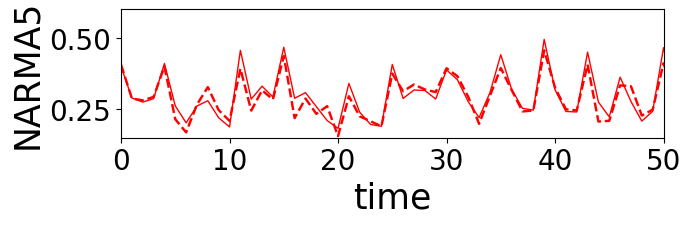

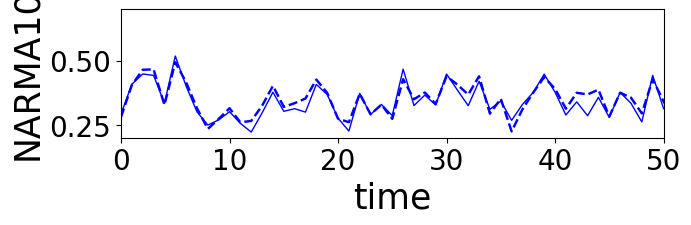

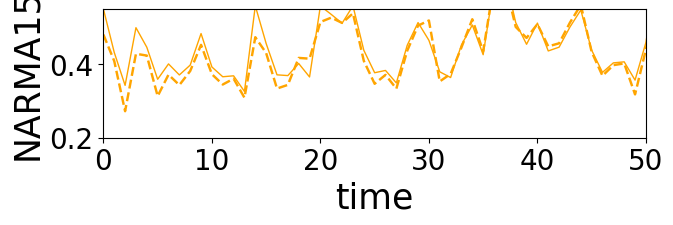

In [14]:
# FigSize=[2.1,3]
FigSize=[7,1.7]
Tplt=50; Save='No'
Colrs = ['r', 'blue', 'orange']

PredictionsPlot(Outs_O, Out_Preds, 0, ['NARMA5', 'NARMA10', 'NARMA15'], Colrs, Tplt, PlotDir,FigSize,[0.15,0.6], Save)
PredictionsPlot(Outs_O, Out_Preds, 1, ['NARMA5', 'NARMA10', 'NARMA15'], Colrs, Tplt, PlotDir,FigSize,[0.2,0.7], Save)
PredictionsPlot(Outs_O, Out_Preds, 2, ['NARMA5', 'NARMA10', 'NARMA15'], Colrs, Tplt, PlotDir,FigSize,[0.2,0.55], Save)

In [15]:

def PredictionsPlot2(OutsO, OutsP, i, TaskNames, Colrs,Tplt, PlotDir, FigSize, Ylims, Save):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size = FigSize
    plt.rcParams["figure.figsize"] = fig_size 
    plt.rcParams['figure.dpi'] = 100
     
    plt.plot(OutsP[i], c=Colrs,lw=2.5, ls='--')
    plt.plot(OutsO[i][500:], c=Colrs,lw=1, label='{:}'.format(TaskNames[i]))
    # plt.legend(fontsize=14, loc='upper left') 
    plt.ylabel(TaskNames[i], fontsize=25)
    plt.xlim(0,Tplt)
    plt.ylim(Ylims)
    plt.xlabel('time', fontsize=25)
    plt.tick_params(axis='both',labelsize=20)
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_d{:d}.svg'.format(i+3)), bbox_inches='tight')
    plt.show()

In [16]:
i=5
Inps, Outs1, Inps_test, Outs1_test = InpGenerate('SinCos1', N_I, Npts_U)
Outs_pred1, Outs_test_pred_S1, MSEs_train, MSEs_pred = RC(GraphsN3_SinCos1_Reps[i][-1], Spectral_radius,\
            N_I, N_O, InpsNodesN3_SinCos1_Reps[i][-1], OutsNodesN3_SinCos1_Reps[i][-1],\
            Inps, Outs1, Inps_test, Outs1_test, Transs, RC_Reps, Return=1)
print(MSEs_pred)
j=0; j2=-1
# j=0; j2=3
Inps, Outs2, Inps_test, Outs2_test = InpGenerate('SinCos2', N_I, Npts_U)
Outs_pred2, Outs_test_pred_S2, MSEs_train, MSEs_pred = RC(GraphsN3_SinCos2_Reps[j][j2], Spectral_radius,\
            N_I, N_O, InpsNodesN3_SinCos2_Reps[j][j2], OutsNodesN3_SinCos2_Reps[j][j2],\
            Inps, Outs2, Inps_test, Outs2_test, Transs, RC_Reps, Return=1)
print(MSEs_pred)

Outs_O = [Outs1_test[0], Outs2_test[0]]
Out_Preds = [Outs_test_pred_S1[0,0], Outs_test_pred_S2[0,0]]

[[1.87170953e-05]
 [0.00000000e+00]]
[[0.0040667]
 [0.       ]]


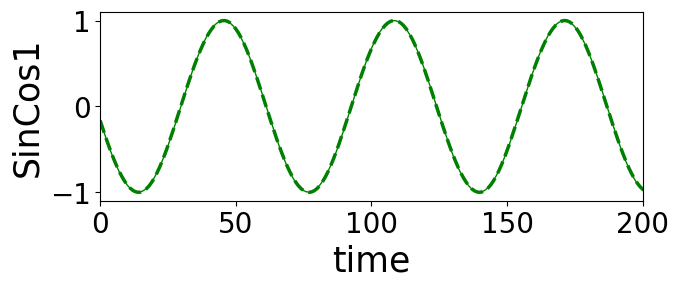

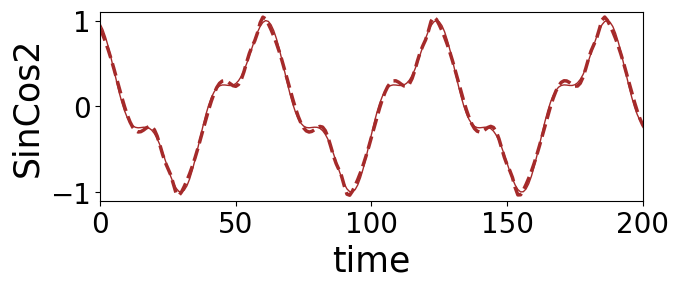

In [18]:
FigSize=[7,2.5]
Tplt=200; Save='No'
Colrs = ['green', 'brown']

PredictionsPlot2(Outs_O, Out_Preds, 0, ['SinCos1', 'SinCos2'], Colrs[0], Tplt, PlotDir,FigSize,[-1.1,1.1], Save)
PredictionsPlot2(Outs_O, Out_Preds, 1, ['SinCos1', 'SinCos2'], Colrs[1], Tplt, PlotDir,FigSize,[-1.1,1.1], Save)

In [19]:
N_I=3; N_O=3
alpha=0.1
Npts_U = 3000; Transs=50
i=1;j=-1
Inps_C, Outs_C, Inps_C_test, Outs_C_test = InpGenerate('Chaos', N_I, Npts_U)
Chaos_Preds = Auto_RC(GraphsN3_Chaos_Reps[i][j], Spectral_radius, alpha, 'Chaos', N_I, N_O,\
                      InpsNodesN3_Chaos_Reps[i][j], OutsNodesN3_Chaos_Reps[i][j], Inps_C, Outs_C, Transs)

print(Chaos_Preds.shape)

(3, 3000)


In [20]:
def PredictionsPlot3(OutsO, OutsP, TaskNames, Colrs, PlotDir, FigSize, Ylims, Save):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size = FigSize
    plt.rcParams["figure.figsize"] = fig_size 
    plt.rcParams['figure.dpi'] = 150
     
    plt.plot(OutsP[0, 400:], OutsP[1, 400:], c=Colrs,lw=1.25, ls='--')
    plt.plot(OutsO[0, 800:], OutsO[1, 800:], c='grey',lw=0.25, label='{:}'.format(TaskNames))
    # plt.legend(fontsize=14, loc='upper left') 
    plt.ylabel('$y$', fontsize=25)
    # plt.xlim(Ylims)
    # plt.ylim(Ylims)
    plt.xlabel('$x$', fontsize=25)
    plt.tick_params(axis='both',labelsize=20)
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_e.svg'), bbox_inches='tight')
    plt.show()

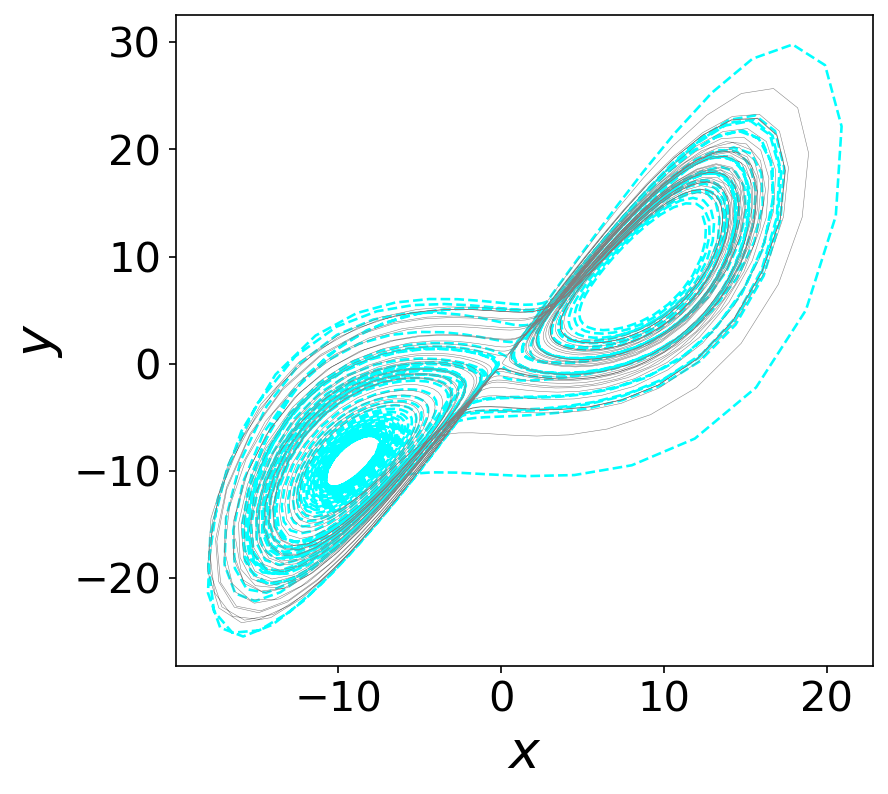

In [21]:
FigSize=[6,5.75]
Save='No'
Colrs = ['cyan']
PredictionsPlot3(Outs_C, Chaos_Preds, ['Chaos'], Colrs[0], PlotDir,FigSize,[-25,25], Save)

In [22]:
N_I=2; N_O=2
alpha=0.23
Npts_U = 2000; Transs=500
i=5
Inps_V, Outs_V, Inps_V_test, Outs_V_test = InpGenerate('VDP', N_I, Npts_U)
VDP_Preds = Auto_RC(GraphsN3_VDP_Reps[i][-1], Spectral_radius, alpha, 'VDP', N_I, N_O,\
                    InpsNodesN3_VDP_Reps[i][-1], OutsNodesN3_VDP_Reps[i][-1], Inps_V, Outs_V, Transs)

print(VDP_Preds.shape)

(2, 2000)


In [23]:
def PredictionsPlot4(OutsO, OutsP, TaskNames, Colrs, PlotDir, FigSize, Ylims, Save):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size = FigSize
    plt.rcParams["figure.figsize"] = fig_size 
    fig, ax = plt.subplots(1, 1, dpi=150)
    
    ax.plot(OutsP[0, 1920:], OutsP[1, 1920:], c=Colrs,lw=5, ls='--')
    ax.plot(OutsO[0, 1900:], OutsO[1, 1900:], c='grey',lw=1, label='{:}'.format(TaskNames))
    # plt.legend(fontsize=14, loc='upper left') 
    ax.set_ylabel('$y$', fontsize=25)
    # plt.xlim(Ylims)
    # plt.ylim(Ylims)
    ax.set_xlabel('$x$', fontsize=25)
    ax.tick_params(axis='both',labelsize=20)
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_f.svg'), bbox_inches='tight')
    plt.show()

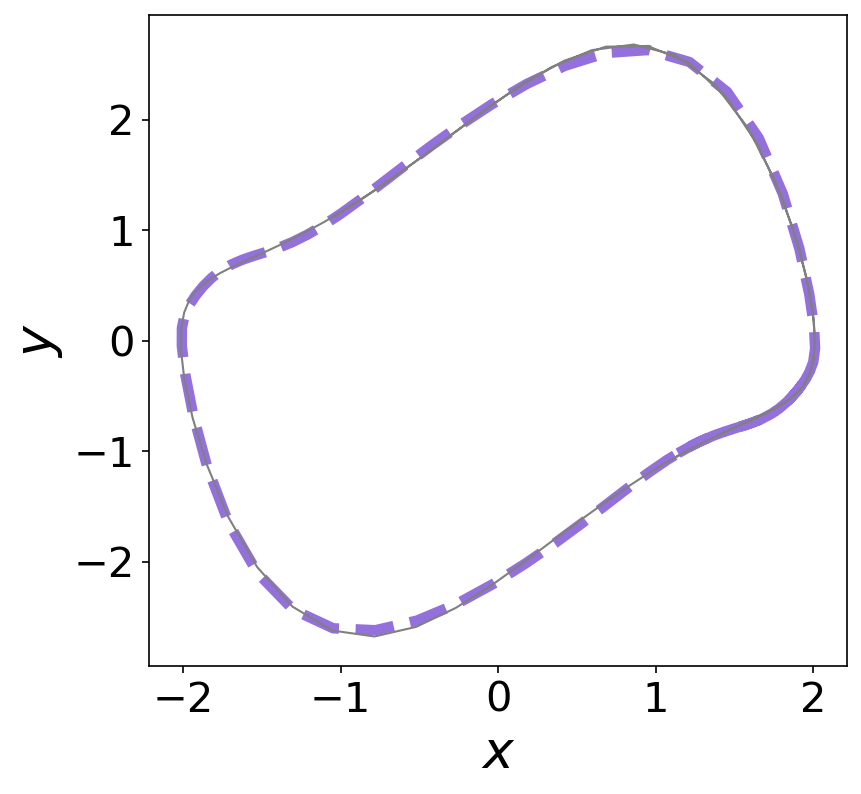

In [24]:
FigSize=[6,5.75]
Save='No'
Colrs = ['mediumpurple']
PredictionsPlot4(Outs_V, VDP_Preds, ['VDP'], Colrs[0], PlotDir,FigSize,[-25,25], Save)

# 2. Network measures

In [25]:
def Plot_Nodes(TaskType, NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG, NetMsrs_Names, Colr, Lims,PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 5.5
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(0,NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,k])
        ##########################################
                  
        ax.plot(NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=0.25,c=Colr[0],alpha=0.6)
        ax.plot(NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=0.25,c=Colr[1],alpha=0.6) 
        ax.plot(NetMsrsC[r,:ZerosLocFirstC,k], zorder=-1, lw=0.25,c=Colr[2],alpha=0.6)
        ax.plot(NetMsrsF[r,:ZerosLocFirstF,k], zorder=-1, lw=0.25,c=Colr[5],alpha=0.6)
        ax.plot(NetMsrsG[r,:ZerosLocFirstG,k], zorder=-1, lw=0.25,c=Colr[6],alpha=0.6)

        ax.scatter(len(NetMsrsA[r,:ZerosLocFirstA,k]), NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='P', s=140, c=Colr[0])
        ax.scatter(len(NetMsrsB[r,:ZerosLocFirstB,k]), NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=60, c=Colr[1])
        ax.scatter(len(NetMsrsC[r,:ZerosLocFirstC,k]), NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=160, c=Colr[2])
        ax.scatter(len(NetMsrsF[r,:ZerosLocFirstF,k]), NetMsrsF[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=80, c=Colr[5])
        ax.scatter(len(NetMsrsG[r,:ZerosLocFirstG,k]), NetMsrsG[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=100, c=Colr[6])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(0,510)
        ax.set_xlabel('Iteration', fontsize=18)
        ax.tick_params(axis='both',labelsize=15)
        ax.set_xscale('symlog')
        
    for r in range(0,NetMsrsA.shape[0],2):#NetMsrsC.shape[0]):
    # for r in range(NetMsrsC.shape[0]):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,k])
        ##########################################               
        ax.plot(NetMsrsD[r,:ZerosLocFirstD,k], zorder=-1, lw=0.25,c=Colr[3],alpha=0.5)
        ax.plot(NetMsrsE[r,:ZerosLocFirstE,k], zorder=-1, lw=0.25,c=Colr[4],alpha=0.5)

        ax.scatter(len(NetMsrsD[r,:ZerosLocFirstD,k]), NetMsrsD[r,ZerosLocFirstD-1,k],zorder=1, marker='D', s=80, c=Colr[3])
        ax.scatter(len(NetMsrsE[r,:ZerosLocFirstE,k]), NetMsrsE[r,ZerosLocFirstE-1,k],zorder=1, marker='s', s=80, c=Colr[4])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=25)
        ax.set_xlim(0,510)
        ax.set_xlabel('Iteration', fontsize=25)
        ax.tick_params(axis='both',labelsize=20)
        ax.set_xscale('log')  
            
    ax.scatter(10000, 10000, marker='P', c=Colr[0],s=140, label='{:}'.format(TaskType[0]))
    ax.scatter(10000, 10000, marker='o', c=Colr[1],s=140, label='{:}'.format(TaskType[1])) 
    ax.scatter(10000, 10000, marker='*', c=Colr[2],s=160, label='{:}'.format(TaskType[2])) 
    ax.scatter(10000, 10000, marker='D', c=Colr[3],s=140, label='{:}'.format(TaskType[3]))
    ax.scatter(10000, 10000, marker='s', c=Colr[4],s=140, label='{:}'.format(TaskType[4]))
    ax.scatter(10000, 10000, marker='^', c=Colr[5],s=140, label='{:}'.format(TaskType[5]))
    ax.scatter(10000, 10000, marker='X', c=Colr[6],s=140, label='{:}'.format(TaskType[6]))
    ax.legend(fontsize=16, loc='upper left') 
    ax.set_xlim(Lims[0])
    ax.set_ylim(Lims[1])
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_a.svg'), bbox_inches='tight')
    plt.show()

## 2.1. Number of nodes with respect to evolutionary iterations

C:\Users\manis\AppData\Local\Temp\ipykernel_33716\3414303015.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,510)


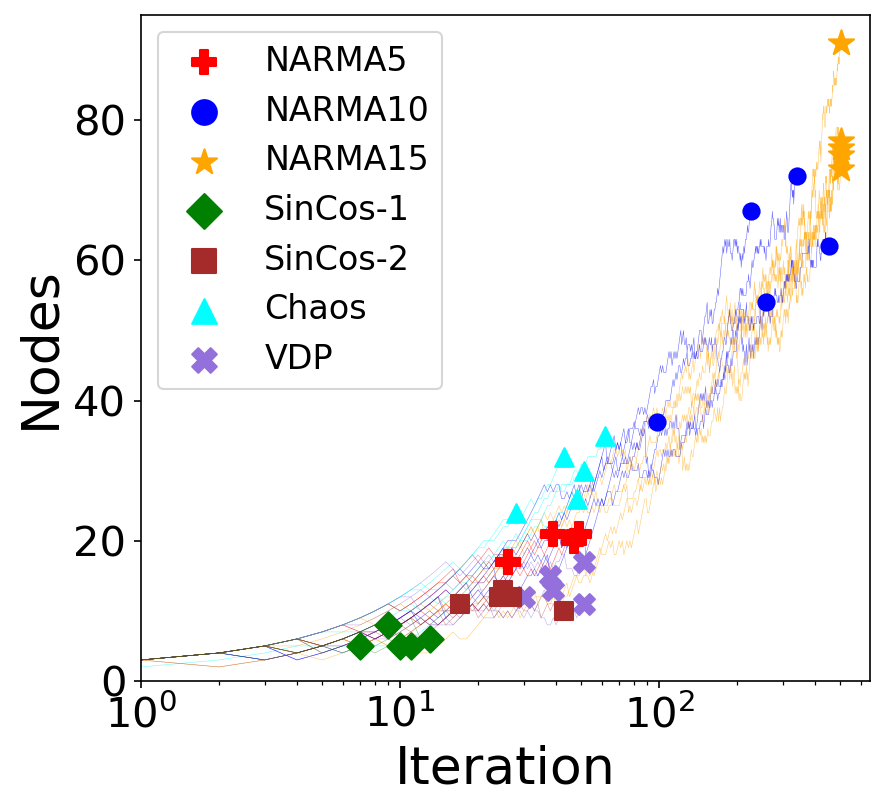

In [26]:
Colr = ['r', 'blue', 'orange', 'green', 'brown', 'cyan', 'mediumpurple']
TaskOrder = ['NARMA5', 'NARMA10', 'NARMA15', 'SinCos-1', 'SinCos-2', 'Chaos', 'VDP']
Save='No'#'Yes'

Plot_Nodes(TaskOrder, NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps[:,:,:], NetMsrsN3_SinCos2_Reps[:,:,:], NetMsrsN3_Chaos_Reps,\
             NetMsrsN3_VDP_Reps, NetMsrsV3_Names, Colr, [[1,650],[0,95]], PlotDir,Save)

C:\Users\manis\AppData\Local\Temp\ipykernel_33716\3414303015.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,510)


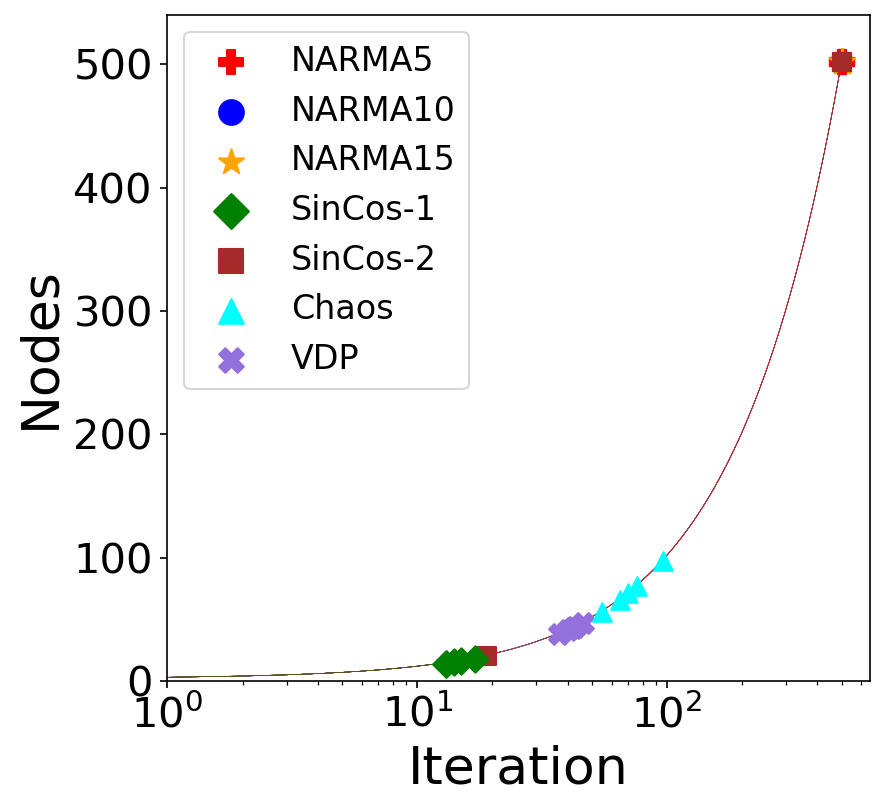

In [27]:
Plot_Nodes(TaskOrder, NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, NetMsrsN1_NARMA15_Reps, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps, NetMsrsN1_Chaos_Reps,\
             NetMsrsN1_VDP_Reps, NetMsrsV3_Names, Colr, [[1,650],[0,540]], PlotDir,Save)

C:\Users\manis\AppData\Local\Temp\ipykernel_33716\3414303015.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,510)


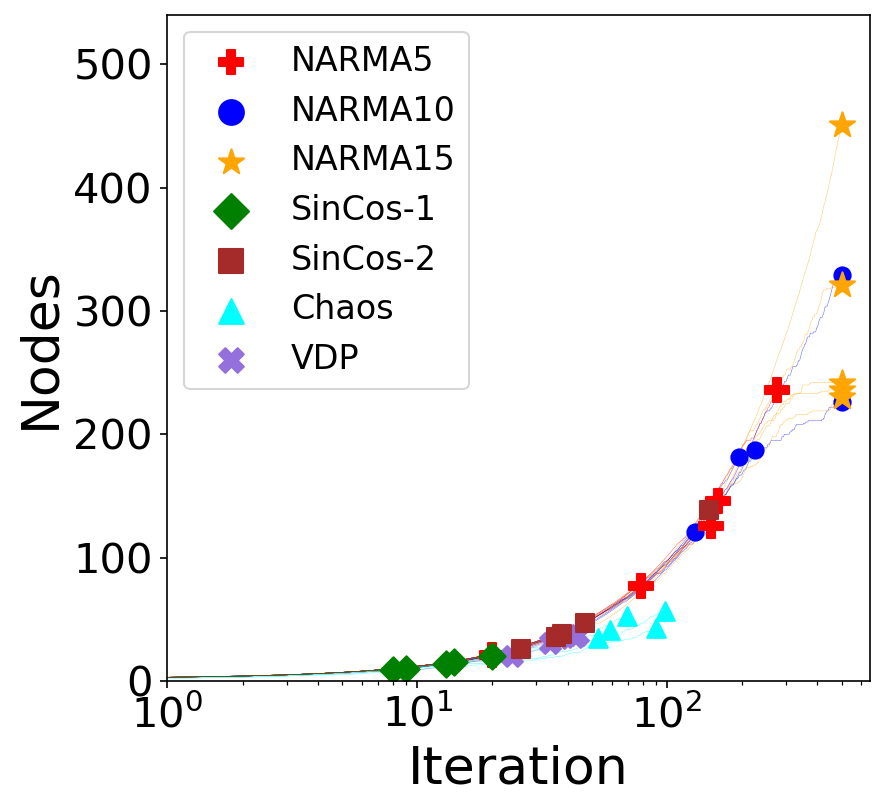

In [28]:
Plot_Nodes(TaskOrder, NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, NetMsrsN2_NARMA15_Reps,\
           NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps, NetMsrsN2_Chaos_Reps,\
             NetMsrsN2_VDP_Reps, NetMsrsV3_Names, Colr, [[1,650],[0,540]], PlotDir,Save)

In [29]:
def Plot_Nodes_Models(TaskType, N1NetMsrsA, N1NetMsrsB, N1NetMsrsC, N2NetMsrsA, N2NetMsrsB, N2NetMsrsC,\
                     N3NetMsrsA, N3NetMsrsB, N3NetMsrsC, NetMsrs_Names, Colr, Lims,PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6.2; fig_size[1] = 5.1
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=100)
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N1NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N1NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(N1NetMsrsC[r,:,k])
        ##########################################
                  
        ax.plot(N1NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1,c='k',alpha=0.5)
        ax.plot(N1NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1,c='k',alpha=0.5) 
        ax.plot(N1NetMsrsC[r,:ZerosLocFirstC,k], zorder=-1, lw=1,c='k',alpha=0.5)
        
        ax.scatter(len(N1NetMsrsB[r,:ZerosLocFirstB,k]), N1NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=130, c=Colr[1])
        ax.scatter(len(N1NetMsrsA[r,:ZerosLocFirstA,k]), N1NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='P', s=100, c=Colr[0])
        ax.scatter(len(N1NetMsrsC[r,:ZerosLocFirstC,k]), N1NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=50, c=Colr[2])

        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
    2
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N2NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N2NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(N2NetMsrsC[r,:,k])
        ##########################################
                  
        ax.plot(N2NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5)
        ax.plot(N2NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5) 
        ax.plot(N2NetMsrsC[r,:ZerosLocFirstC,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5)

        ax.scatter(len(N2NetMsrsA[r,:ZerosLocFirstA,k]), N2NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='P',edgecolors='deepskyblue', s=100, c=Colr[0])
        ax.scatter(len(N2NetMsrsB[r,:ZerosLocFirstB,k]), N2NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o',edgecolors='deepskyblue', s=80, c=Colr[1])
        ax.scatter(len(N2NetMsrsC[r,:ZerosLocFirstC,k]), N2NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*',edgecolors='deepskyblue', s=150, c=Colr[2])

        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N3NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N3NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(N3NetMsrsC[r,:,k])
        ##########################################
                  
        ax.plot(N3NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, c='pink',alpha=1)
        ax.plot(N3NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, c='pink',alpha=1) 
        ax.plot(N3NetMsrsC[r,:ZerosLocFirstC,k], zorder=-1, lw=1, c='pink',alpha=1)

        ax.scatter(len(N3NetMsrsA[r,:ZerosLocFirstA,k]), N3NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='P',edgecolors='pink', s=120, c=Colr[0])
        ax.scatter(len(N3NetMsrsB[r,:ZerosLocFirstB,k]), N3NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o',edgecolors='pink', s=80, c=Colr[1])
        ax.scatter(len(N3NetMsrsC[r,:ZerosLocFirstC,k]), N3NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*',edgecolors='pink', s=150, c=Colr[2])

        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    ax.set_ylabel(NetMsrs_Names[k], fontsize=22)
    ax.set_xlabel('Iteration', fontsize=22)
    ax.tick_params(axis='both',labelsize=15)
    # ax.set_xscale('log')  
            
    ax.scatter(10000, 10000, marker='P', c=Colr[0],s=100, label='{:}'.format(TaskType[0]))
    ax.scatter(10000, 10000, marker='o', c=Colr[1],s=100, label='{:}'.format(TaskType[1])) 
    ax.scatter(10000, 10000, marker='*', c=Colr[2],s=100, label='{:}'.format(TaskType[2])) 
    ax.plot([10000,10100], [10000,10100], c='k', label='N1') 
    ax.plot([10000,10100], [10000,10100], c='deepskyblue', label='N2') 
    ax.plot([10000,10100], [10000,10100], c='pink', label='N3') 
    
    ax.legend(fontsize=16, loc='upper left') 
    ax.set_xlim(Lims[0])
    ax.set_ylim(Lims[1])
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig3_a1.svg'), bbox_inches='tight')
    plt.show()

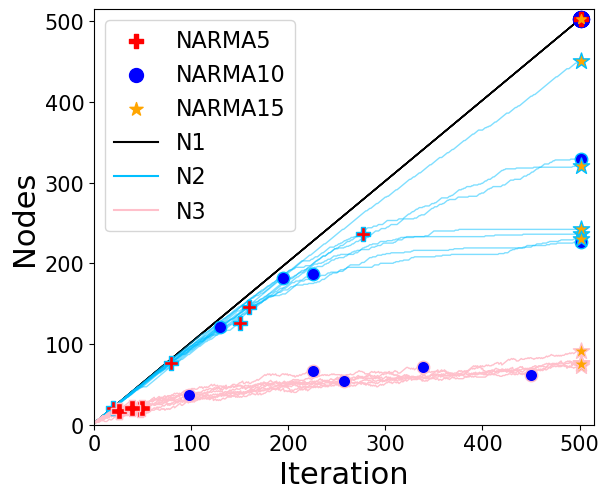

In [30]:
Save='No'
Plot_Nodes_Models(TaskOrder, NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, NetMsrsN1_NARMA15_Reps,\
            NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, NetMsrsN2_NARMA15_Reps,\
            NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps,\
            NetMsrsV3_Names, Colr, [[0,515],[0,515]], PlotDir,Save)

In [31]:
def Plot_Nodes_Models2(TaskType, N1NetMsrsA, N1NetMsrsB, N2NetMsrsA, N2NetMsrsB, \
                     N3NetMsrsA, N3NetMsrsB, NetMsrs_Names, Colr, Lims,PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6.2; fig_size[1] = 5.2
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=100)
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N1NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N1NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N1NetMsrsA[r,:ZerosLocFirstA,k], zorder=1, lw=1,c='k',alpha=1)
        ax.plot(N1NetMsrsB[r,:ZerosLocFirstB,k], zorder=1, lw=1,c='k',alpha=1) 
        
        ax.scatter(len(N1NetMsrsB[r,:ZerosLocFirstB,k]), N1NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='s',edgecolors='k', linewidth=2, s=100, c=Colr[4])
        ax.scatter(len(N1NetMsrsA[r,:ZerosLocFirstA,k]), N1NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='D',edgecolors='k', linewidth=2, s=100, c=Colr[3])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
    
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N2NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N2NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N2NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5)
        ax.plot(N2NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5) 
        
        ax.scatter(len(N2NetMsrsA[r,:ZerosLocFirstA,k]), N2NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='D',edgecolors='deepskyblue',linewidth=2, s=100, c=Colr[3])
        ax.scatter(len(N2NetMsrsB[r,:ZerosLocFirstB,k]), N2NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='s',edgecolors='deepskyblue', linewidth=2, s=100, c=Colr[4])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N3NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N3NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N3NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, c='pink',alpha=1)
        ax.plot(N3NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, c='pink',alpha=1) 
        
        ax.scatter(len(N3NetMsrsA[r,:ZerosLocFirstA,k]), N3NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='D',edgecolors='pink', linewidth=2, s=100, c=Colr[3])
        ax.scatter(len(N3NetMsrsB[r,:ZerosLocFirstB,k]), N3NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='s',edgecolors='pink', linewidth=2, s=100, c=Colr[4])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    ax.set_ylabel(NetMsrs_Names[k], fontsize=22)
    ax.set_xlabel('Iteration', fontsize=22)
    ax.tick_params(axis='both',labelsize=15)
    # ax.set_xscale('log')  
            
    ax.scatter(10000, 10000, marker='D', c=Colr[3],s=100, label='{:}'.format(TaskType[3]))
    ax.scatter(10000, 10000, marker='s', c=Colr[4],s=100, label='{:}'.format(TaskType[4])) 
    ax.plot([10000,10100], [10000,10100], c='k', label='N1') 
    ax.plot([10000,10100], [10000,10100], c='deepskyblue', label='N2') 
    ax.plot([10000,10100], [10000,10100], c='pink', label='N3') 
    
    ax.legend(fontsize=16, loc='upper left') 
    ax.set_xlim(Lims[0])
    ax.set_ylim(Lims[1])
    ax.set_xscale('log') 
    ax.set_yscale('log')
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig4_a1.svg'), bbox_inches='tight')
    plt.show()

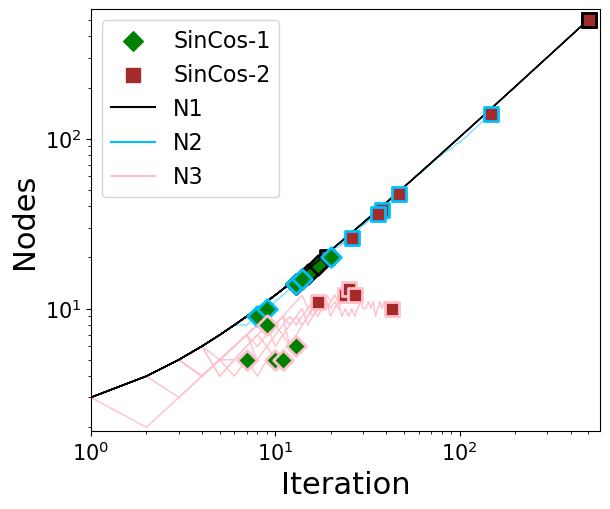

In [32]:
Save='No'
Plot_Nodes_Models2(TaskOrder, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps,\
            NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps,\
            NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps,\
            NetMsrsV3_Names, Colr, [[1,578],[1.9,580]], PlotDir,Save)

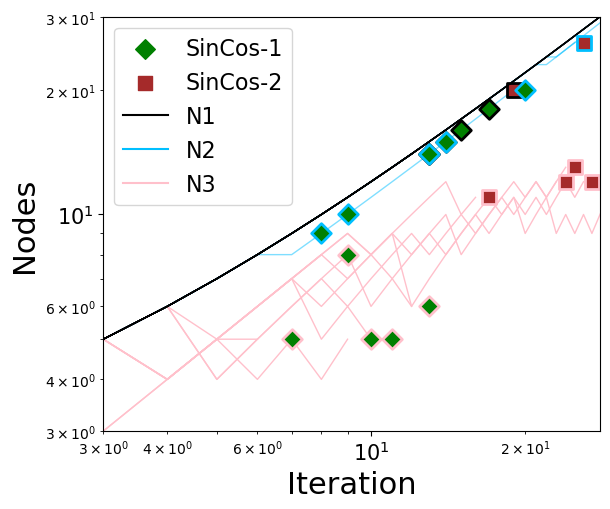

In [33]:
Save='No'
Plot_Nodes_Models2(TaskOrder, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps,\
            NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps,\
            NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps,\
            NetMsrsV3_Names, Colr, [[3,28],[3,30]], PlotDir,Save)

In [34]:
def Plot_Nodes_Models3(TaskType, N1NetMsrsA, N1NetMsrsB, N2NetMsrsA, N2NetMsrsB, \
                     N3NetMsrsA, N3NetMsrsB, NetMsrs_Names, Colr, Lims,PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6.35; fig_size[1] = 5.1
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=100)
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N1NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N1NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N1NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1,c='k',alpha=1)
        ax.plot(N1NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1,c='k',alpha=1) 
        
        ax.scatter(len(N1NetMsrsB[r,:ZerosLocFirstB,k]), N1NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='X',edgecolors='k', linewidth=2, s=160, c=Colr[6])
        ax.scatter(len(N1NetMsrsA[r,:ZerosLocFirstA,k]), N1NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='^',edgecolors='k', linewidth=2, s=160, c=Colr[5])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
    
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N2NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N2NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N2NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5)
        ax.plot(N2NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, ls='-', c='deepskyblue',alpha=0.5) 
        
        ax.scatter(len(N2NetMsrsA[r,:ZerosLocFirstA,k]), N2NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='^',edgecolors='deepskyblue',linewidth=2, s=160, c=Colr[5])
        ax.scatter(len(N2NetMsrsB[r,:ZerosLocFirstB,k]), N2NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='X',edgecolors='deepskyblue', linewidth=2, s=160, c=Colr[6])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    for r in range(0,N1NetMsrsA.shape[0],2):
        k=0
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(N3NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(N3NetMsrsB[r,:,k])
        ##########################################
                  
        ax.plot(N3NetMsrsA[r,:ZerosLocFirstA,k], zorder=-1, lw=1, c='pink',alpha=1)
        ax.plot(N3NetMsrsB[r,:ZerosLocFirstB,k], zorder=-1, lw=1, c='pink',alpha=1) 
        
        ax.scatter(len(N3NetMsrsA[r,:ZerosLocFirstA,k]), N3NetMsrsA[r,ZerosLocFirstA-1,k], zorder=1, marker='^',edgecolors='pink', linewidth=2, s=160, c=Colr[5])
        ax.scatter(len(N3NetMsrsB[r,:ZerosLocFirstB,k]), N3NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='X',edgecolors='pink', linewidth=2, s=170, c=Colr[6])
        
        ax.tick_params(axis='both',labelsize=15)
        # ax.set_xscale('symlog')
        
    ax.set_ylabel(NetMsrs_Names[k], fontsize=22)
    ax.set_xlabel('Iteration', fontsize=22)
    ax.tick_params(axis='both',labelsize=15)
    
            
    ax.scatter(10000, 10000, marker='^', c=Colr[5],s=150, label='{:}'.format(TaskType[5]))
    ax.scatter(10000, 10000, marker='X', c=Colr[6],s=150, label='{:}'.format(TaskType[6])) 
    ax.plot([10000,10100], [10000,10100], c='k', label='N1') 
    ax.plot([10000,10100], [10000,10100], c='deepskyblue', label='N2') 
    ax.plot([10000,10100], [10000,10100], c='pink', label='N3') 
#     ax.set_xscale('log') 
#     ax.set_yscale('log') 
    
    ax.legend(fontsize=16, loc='upper left') 
    ax.set_xlim(Lims[0])
    ax.set_ylim(Lims[1])
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig5_a1.svg'), bbox_inches='tight')
    plt.show()

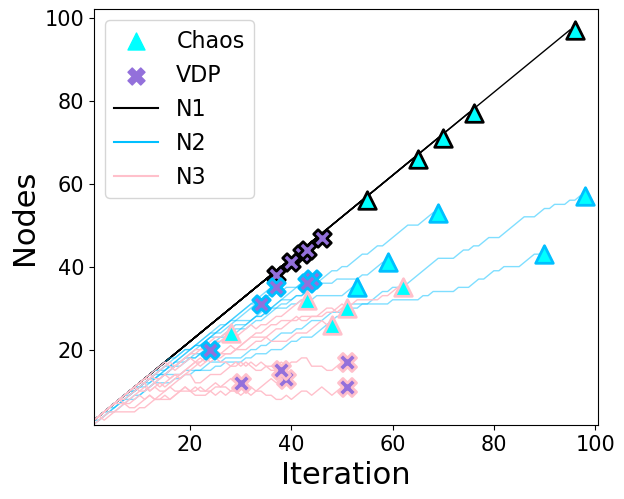

In [35]:
Save='No'
Plot_Nodes_Models3(TaskOrder, NetMsrsN1_Chaos_Reps, NetMsrsN1_VDP_Reps,\
            NetMsrsN2_Chaos_Reps, NetMsrsN2_VDP_Reps,\
            NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps,\
            NetMsrsV3_Names, Colr, [[1,100.5],[1.9,102]], PlotDir,Save)

## 2.2. Average degrees

In [36]:
def AvgDegree(NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG):
    m=2
    Density_X_data=[]; Density_Y_data=[]
    for r in range(10):
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,m])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,m])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,m])
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,m])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,m])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,m])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,m])
                
        Density_Y_data.append([NetMsrsA[r,ZerosLocFirstA-1,m], NetMsrsB[r,ZerosLocFirstB-1,m],\
                              NetMsrsC[r,ZerosLocFirstC-1,m], NetMsrsD[r,ZerosLocFirstD-1,m],\
                              NetMsrsE[r,ZerosLocFirstE-1,m], NetMsrsF[r,ZerosLocFirstF-1,m], NetMsrsG[r,ZerosLocFirstG-1,m]])
    return np.mean(np.asarray(Density_Y_data).flatten())
    

In [37]:
AvgDeg_N1 = AvgDegree(NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, \
                                NetMsrsN1_NARMA15_Reps, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps, NetMsrsN1_Chaos_Reps,\
                                NetMsrsN1_VDP_Reps)
AvgDeg_N2 = AvgDegree(NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, \
                                NetMsrsN2_NARMA15_Reps, NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps, NetMsrsN2_Chaos_Reps,\
                                NetMsrsN2_VDP_Reps)
AvgDeg_N3 = AvgDegree(NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, \
                                NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps, NetMsrsN3_Chaos_Reps,\
                                NetMsrsN3_VDP_Reps)
print('Average degrees of end networks for the following models:','\nN1:',AvgDeg_N1,'\nN2:', AvgDeg_N2,'\nN3:', AvgDeg_N3)

Average degrees of end networks for the following models: 
N1: 2.859681172006643 
N2: 2.610216486381662 
N3: 1.9412583205322773


## 2.2. Evolved networks' nodes vs Average degrees plot

In [38]:
def Plot_NAvgDeg(TaskType, NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG,\
                   NetMsrs_Names, AvgDeg, Colr, L,PlotDir, Ptype,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 5.5
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(10):#NetMsrsA.shape[0]):
        k=2
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA[r,ZerosLocFirstA-1,L], NetMsrsA[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=90, c=Colr[0])
        ax.scatter(NetMsrsB[r,ZerosLocFirstB-1,L], NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=50, c=Colr[1])
        ax.scatter(NetMsrsC[r,ZerosLocFirstC-1,L], NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=140, c=Colr[2])
        ax.scatter(NetMsrsF[r,ZerosLocFirstF-1,L], NetMsrsF[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=60, c=Colr[5])
        ax.scatter(NetMsrsG[r,ZerosLocFirstG-1,L], NetMsrsG[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=80, c=Colr[6])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15) 
    
    for r in range(10): #(NetMsrsC.shape[0]):
        k=2; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD[r+jj,ZerosLocFirstD-1,L], NetMsrsD[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=40, c=Colr[3])
        ax.scatter(NetMsrsE[r+jj,ZerosLocFirstE-1,L], NetMsrsE[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=30, c=Colr[4])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15)
                                  
    N_s_a = np.linspace(1.00001, 0.001, 100)
    N_s = np.linspace(1, 600, 50)
    N_s = np.append(N_s_a, N_s)
    Density_lower = 1/(N_s)
    
    if Ptype==1:
        ax.axhline(y=AvgDeg_N1, color='k', linestyle='--', label=r'$\delta=2.86/N$')
        ax.set_ylabel('Average In-Degree (N1)', fontsize=25)
        ax.set_xlim(2,520)

    if Ptype==2:
        ax.axhline(y=AvgDeg_N2, color='deepskyblue', linestyle='--', label=r'$\delta=2.61/N$')
        ax.set_ylabel('Average In-Degree (N2)', fontsize=25)
        ax.set_xlim(2,520)
        start, end = ax.get_ylim()
        
    if Ptype==3:
        ax.axhline(y=AvgDeg_N3, color='pink', linestyle='--', label=r'$\delta=1.94/N$')
        ax.set_ylabel('Average In-Degree (N3)', fontsize=25)
        ax.set_xlim(2,95)
                  
    ax.legend(fontsize=16, loc='upper right') 
    ax.set_ylim(0.9,3.4)
    ax.set_xlabel('$Nodes$', fontsize=25)
    ax.tick_params(axis='both',labelsize=16)

    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig6_c3.svg'), bbox_inches='tight')
    plt.show()

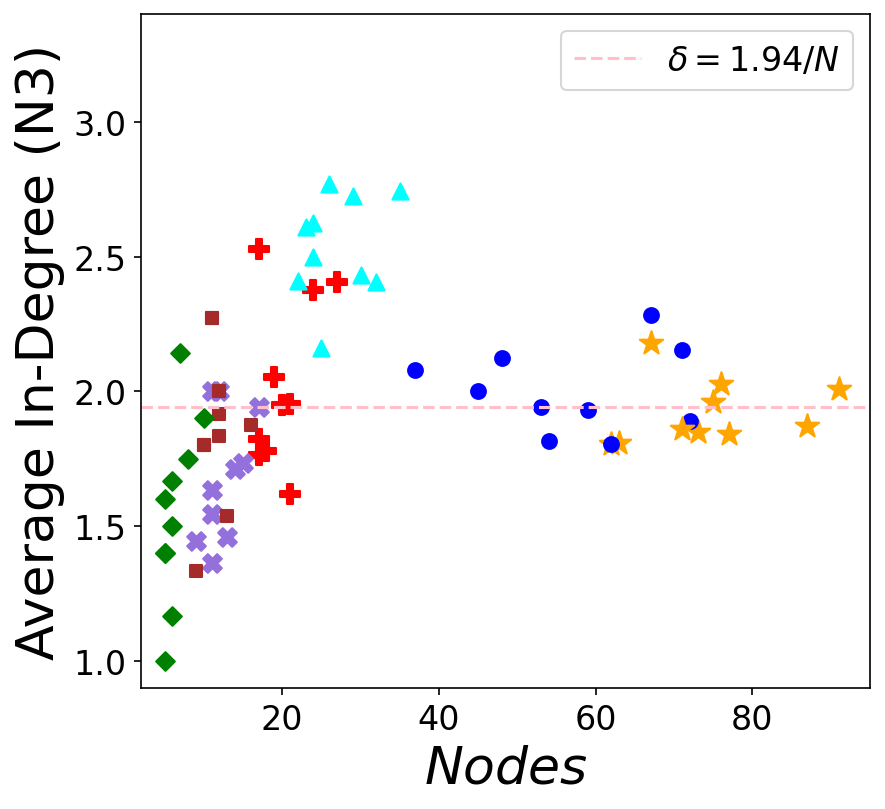

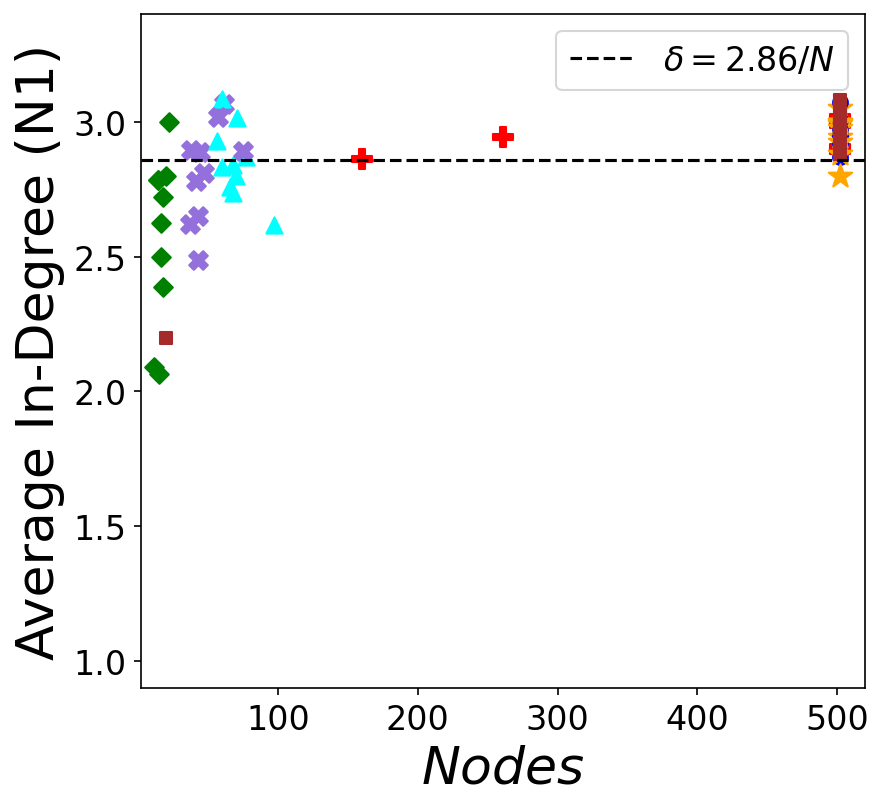

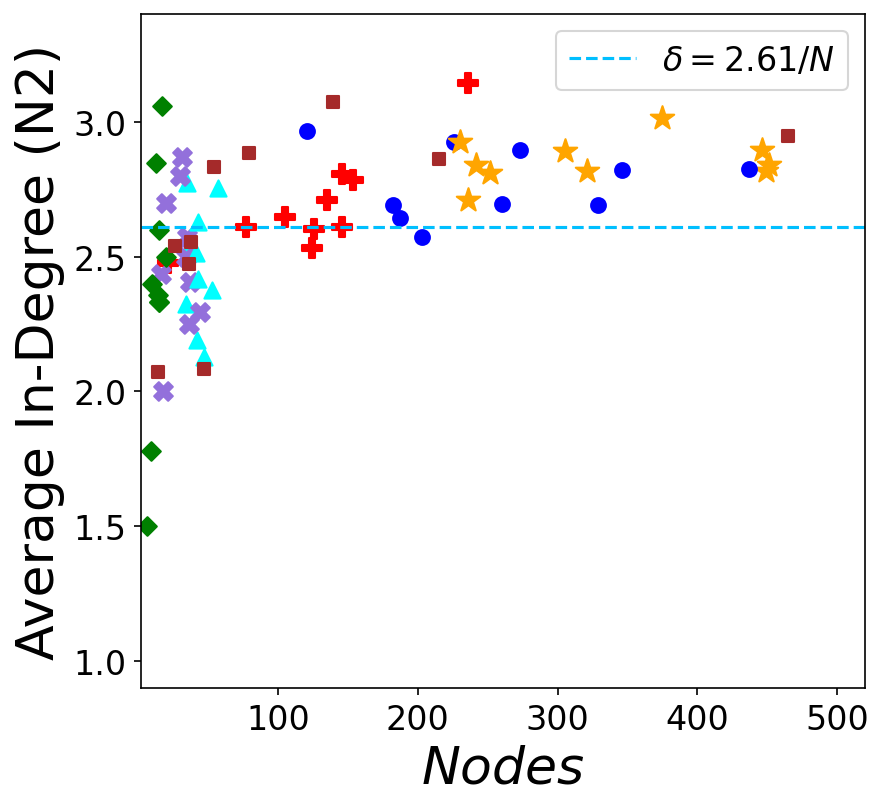

In [39]:
Save='No'#'Yes'

Plot_NAvgDeg(TaskOrder, NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps[:,:,:], NetMsrsN3_SinCos2_Reps[:,:,:],\
             NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps, NetMsrsV3_Names, AvgDeg_N3, Colr, 0, PlotDir,3,Save)

Plot_NAvgDeg(TaskOrder, NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, NetMsrsN1_NARMA15_Reps, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps,\
             NetMsrsN1_Chaos_Reps, NetMsrsN1_VDP_Reps, NetMsrsV3_Names, AvgDeg_N1, Colr, 0,PlotDir,1,Save)

Plot_NAvgDeg(TaskOrder, NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, NetMsrsN2_NARMA15_Reps, NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps,\
             NetMsrsN2_Chaos_Reps, NetMsrsN2_VDP_Reps, NetMsrsV3_Names, AvgDeg_N2, Colr, 0,PlotDir,2,Save)

## 2.2. Evolved networks' nodes vs density plots

In [40]:
def Plot_NDensity(TaskType, NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG,\
                   NetMsrs_Names, AvgDeg, Colr, L,PlotDir, Ptype,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 5.5
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(10):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA[r,ZerosLocFirstA-1,L], NetMsrsA[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=90, c=Colr[0])
        ax.scatter(NetMsrsB[r,ZerosLocFirstB-1,L], NetMsrsB[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=50, c=Colr[1])
        ax.scatter(NetMsrsC[r,ZerosLocFirstC-1,L], NetMsrsC[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=140, c=Colr[2])
        ax.scatter(NetMsrsF[r,ZerosLocFirstF-1,L], NetMsrsF[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=60, c=Colr[5])
        ax.scatter(NetMsrsG[r,ZerosLocFirstG-1,L], NetMsrsG[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=80, c=Colr[6])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15) 
    
    for r in range(10): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD[r+jj,ZerosLocFirstD-1,L], NetMsrsD[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=40, c=Colr[3])
        ax.scatter(NetMsrsE[r+jj,ZerosLocFirstE-1,L], NetMsrsE[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=30, c=Colr[4])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(0.03, end+0.0, 0.13))
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start-16, end, 20))
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(ScalarFormatter())


    N_s_a = np.linspace(1.00001, 0.001, 100)
    N_s = np.linspace(1, 600, 50)
    N_s = np.append(N_s_a, N_s)
    Density_lower = 1/(N_s)
    
    ax.plot(N_s, Density_lower, ls='dashed', lw=1.5, c='grey', zorder=0)
    Density_upper = 5/(N_s)
    ax.plot(N_s, Density_upper, ls='dashed', lw=1.5, c='grey', zorder=0)
    
    if Ptype==1:
        Density_avg = AvgDeg/(N_s)
        ax.plot(N_s, Density_avg, ls='dashed', lw=1.5, c='k', zorder=0,\
                 label=r'$\delta=2.86/N$') 
        Density_m = 3/(N_s)
        ax.plot(N_s, Density_m, ls='dashed', lw=1, c='b', zorder=0,\
                     label=r'$\delta=3/N$')
        
        ax.set_ylim(0.003,0.75)
        ax.set_xlim(3,580) 
        
          
    if Ptype==2:
        Density_avg = AvgDeg/(N_s)
        ax.plot(N_s, Density_avg, ls='dashed', lw=1.5, c='deepskyblue', zorder=0,\
                 label=r'$\delta=2.61/N$') 
        Density_m = 3/(N_s)
        ax.plot(N_s, Density_m, ls='dashed', lw=1, c='b', zorder=0,\
                     label=r'$\delta=3/N$')
        
        ax.set_ylim(0.003,0.75) 
        ax.set_xlim(3,580)
        start, end = ax.get_ylim()
        
    if Ptype==3:  
        Density_avg = AvgDeg/(N_s)
        ax.plot(N_s, Density_avg, ls='dashed', lw=1.5, c='pink', zorder=0,\
                 label=r'$\delta=1.94/N$') 
        Density_m = 3/(N_s)
        ax.plot(N_s, Density_m, ls='solid', lw=1, c='b', zorder=0,\
                     label=r'$\delta=3/N$')
        ax.set_ylim(0.02,0.43)
        ax.set_xlim(4.5,110)
                  
    ax.legend(fontsize=16, loc='upper right') 
    ax.set_xlabel('$log(N)$', fontsize=25)
    ax.set_ylabel('$log(\delta)$', fontsize=25)
    ax.tick_params(axis='both',labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig6_a.svg'), bbox_inches='tight')
    plt.show()

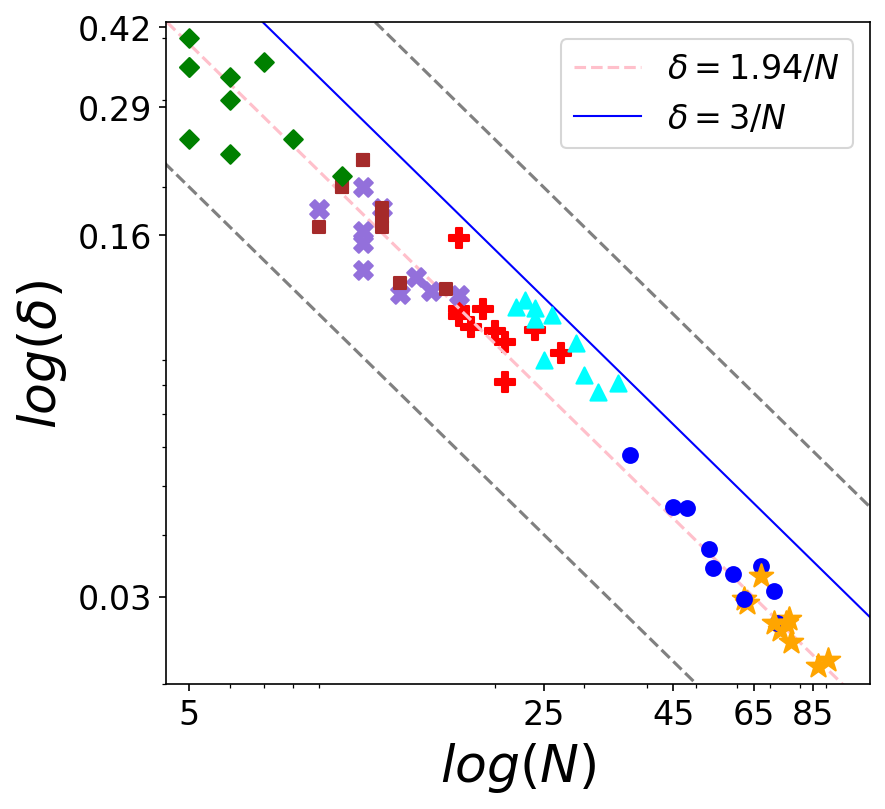

In [41]:
Save='No'#'Yes'

Plot_NDensity(TaskOrder, NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps[:,:,:], NetMsrsN3_SinCos2_Reps[:,:,:],\
             NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps, NetMsrsV3_Names, AvgDeg_N3, Colr, 0,PlotDir,3,Save)

In [42]:
def Plot_NDensity_3(TaskType, NetMsrsA1, NetMsrsB1, NetMsrsC1, NetMsrsD1, NetMsrsE1, NetMsrsF1, NetMsrsG1,\
                  NetMsrsA2, NetMsrsB2, NetMsrsC2, NetMsrsD2, NetMsrsE2, NetMsrsF2, NetMsrsG2,\
                  NetMsrsA3, NetMsrsB3, NetMsrsC3, NetMsrsD3, NetMsrsE3, NetMsrsF3, NetMsrsG3,\
                  NetMsrs_Names, AvgDeg_N1, AvgDeg_N2, AvgDeg_N3, Colr, L, PlotDir, Ptype, Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 5.5
    plt.rcParams["figure.figsize"] = fig_size  
    
    Colr=['pink','deepskyblue','k']
    ########## N1################################################################################################
    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA1[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB1[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC1[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF1[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG1[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA1[r,ZerosLocFirstA-1,L], NetMsrsA1[r,ZerosLocFirstA-1,k],zorder=1, marker='P', s=30, c=Colr[2])
        ax.scatter(NetMsrsB1[r,ZerosLocFirstB-1,L], NetMsrsB1[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=20, c=Colr[2])
        ax.scatter(NetMsrsC1[r,ZerosLocFirstC-1,L], NetMsrsC1[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=30, c=Colr[2])
        ax.scatter(NetMsrsF1[r,ZerosLocFirstF-1,L], NetMsrsF1[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=30, c=Colr[2])
        ax.scatter(NetMsrsG1[r,ZerosLocFirstG-1,L], NetMsrsG1[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=30, c=Colr[2])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD1[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE1[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD1[r+jj,ZerosLocFirstD-1,L], NetMsrsD1[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=10, c=Colr[2])
        ax.scatter(NetMsrsE1[r+jj,ZerosLocFirstE-1,L], NetMsrsE1[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=10, c=Colr[2])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
            
    ########## N2################################################################################################
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA2[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB2[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC2[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF2[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG2[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA2[r,ZerosLocFirstA-1,L], NetMsrsA2[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=30, c=Colr[1])
        ax.scatter(NetMsrsB2[r,ZerosLocFirstB-1,L], NetMsrsB2[r,ZerosLocFirstB-1,k],zorder=-1, marker='o', s=20, c=Colr[1])
        ax.scatter(NetMsrsC2[r,ZerosLocFirstC-1,L], NetMsrsC2[r,ZerosLocFirstC-1,k],zorder=-1, marker='*', s=30, c=Colr[1])
        ax.scatter(NetMsrsF2[r,ZerosLocFirstF-1,L], NetMsrsF2[r,ZerosLocFirstF-1,k],zorder=-1, marker='^', s=30, c=Colr[1])
        ax.scatter(NetMsrsG2[r,ZerosLocFirstG-1,L], NetMsrsG2[r,ZerosLocFirstG-1,k],zorder=-1, marker='X', s=30, c=Colr[1])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD2[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE2[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD2[r+jj,ZerosLocFirstD-1,L], NetMsrsD2[r+jj,ZerosLocFirstD-1,k],zorder=-1, marker='D', s=10, c=Colr[1])
        ax.scatter(NetMsrsE2[r+jj,ZerosLocFirstE-1,L], NetMsrsE2[r+jj,ZerosLocFirstE-1,k],zorder=-1, marker='s', s=10, c=Colr[1])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')
                    
    ########## N3################################################################################################
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA3[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB3[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC3[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF3[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG3[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA3[r,ZerosLocFirstA-1,L], NetMsrsA3[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=30, c=Colr[0])
        ax.scatter(NetMsrsB3[r,ZerosLocFirstB-1,L], NetMsrsB3[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=20, c=Colr[0])
        ax.scatter(NetMsrsC3[r,ZerosLocFirstC-1,L], NetMsrsC3[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=30, c=Colr[0])
        ax.scatter(NetMsrsF3[r,ZerosLocFirstF-1,L], NetMsrsF3[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=30, c=Colr[0])
        ax.scatter(NetMsrsG3[r,ZerosLocFirstG-1,L], NetMsrsG3[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=30, c=Colr[0])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=15) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD3[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE3[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD3[r+jj,ZerosLocFirstD-1,L], NetMsrsD3[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=10, c=Colr[0])
        ax.scatter(NetMsrsE3[r+jj,ZerosLocFirstE-1,L], NetMsrsE3[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=10, c=Colr[0])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=16)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(0.01, 0.45, 0.09))
    start, end = ax.get_xlim()
       
    
    ax.scatter(10000, 10000, marker='s', c=Colr[2],s=120, label=r'N1 ($\delta=2.86/N$)') 
    ax.scatter(10000, 10000, marker='s', c=Colr[1],s=120, label=r'N2 ($\delta=2.61/N$)') 
    ax.scatter(10000, 10000, marker='s', c=Colr[0],s=120, label=r'N3 ($\delta=1.94/N$)') 
    

    N_s_a = np.linspace(0.00001, 0.001, 100)
    N_s = np.linspace(1, 600, 50)
    N_s = np.append(N_s_a, N_s)
    Density_lower = 1/(N_s)
    
    ax.plot(N_s, Density_lower, ls='dashed', lw=1.5, c='grey', zorder=0)
    Density_upper = 5/(N_s)
    ax.plot(N_s, Density_upper, ls='dashed', lw=1.5, c='grey', zorder=0)
    
    ###N1
    Density_avg = AvgDeg_N1/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=0.75, c=Colr[2], zorder=0)
               
#     ###N2      
    Density_avg = AvgDeg_N2/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=0.75, c=Colr[1], zorder=0)
           
#     #####N3
    Density_avg = AvgDeg_N3/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=0.75, c=Colr[0], zorder=0)
    Density_m = 3/(N_s)
    ax.plot(N_s, Density_m, lw=1, c='b', zorder=0,\
                 label=r'$\delta=3/N$', alpha=0.9)
       
    ax.set_ylim(0.005,0.45)
    ax.set_xlim(4.5,610)
                  
    ax.set_xlabel('$log(N)$', fontsize=25)
    ax.set_ylabel('$log(\delta)$', fontsize=25)
    
    ax.legend(fontsize=16, loc='upper right') 
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig6_b.svg'), bbox_inches='tight')
    plt.show()
    
def Plot_NDensity_3_In(TaskType, NetMsrsA1, NetMsrsB1, NetMsrsC1, NetMsrsD1, NetMsrsE1, NetMsrsF1, NetMsrsG1,\
                  NetMsrsA2, NetMsrsB2, NetMsrsC2, NetMsrsD2, NetMsrsE2, NetMsrsF2, NetMsrsG2,\
                  NetMsrsA3, NetMsrsB3, NetMsrsC3, NetMsrsD3, NetMsrsE3, NetMsrsF3, NetMsrsG3,\
                  NetMsrs_Names, AvgDeg_N1, AvgDeg_N2, AvgDeg_N3, Colr, L, PlotDir, Ptype, Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 4.5
    plt.rcParams["figure.figsize"] = fig_size  
    
    Colr=['pink','deepskyblue','k']
    ########## N1################################################################################################
    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA1[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB1[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC1[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF1[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG1[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA1[r,ZerosLocFirstA-1,L], NetMsrsA1[r,ZerosLocFirstA-1,k],zorder=1, marker='P', s=60, c=Colr[2])
        ax.scatter(NetMsrsB1[r,ZerosLocFirstB-1,L], NetMsrsB1[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=60, c=Colr[2])
        ax.scatter(NetMsrsC1[r,ZerosLocFirstC-1,L], NetMsrsC1[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=30, c=Colr[2])
        ax.scatter(NetMsrsF1[r,ZerosLocFirstF-1,L], NetMsrsF1[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=30, c=Colr[2])
        ax.scatter(NetMsrsG1[r,ZerosLocFirstG-1,L], NetMsrsG1[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=30, c=Colr[2])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD1[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE1[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD1[r+jj,ZerosLocFirstD-1,L], NetMsrsD1[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=10, c=Colr[2])
        ax.scatter(NetMsrsE1[r+jj,ZerosLocFirstE-1,L], NetMsrsE1[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=50, c=Colr[2])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
            
    ########## N2################################################################################################
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA2[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB2[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC2[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF2[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG2[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA2[r,ZerosLocFirstA-1,L], NetMsrsA2[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=170, c=Colr[1])
        ax.scatter(NetMsrsB2[r,ZerosLocFirstB-1,L], NetMsrsB2[r,ZerosLocFirstB-1,k],zorder=-1, marker='o', s=170, c=Colr[1])
        ax.scatter(NetMsrsC2[r,ZerosLocFirstC-1,L], NetMsrsC2[r,ZerosLocFirstC-1,k],zorder=-1, marker='*', s=30, c=Colr[1])
        ax.scatter(NetMsrsF2[r,ZerosLocFirstF-1,L], NetMsrsF2[r,ZerosLocFirstF-1,k],zorder=-1, marker='^', s=30, c=Colr[1])
        ax.scatter(NetMsrsG2[r,ZerosLocFirstG-1,L], NetMsrsG2[r,ZerosLocFirstG-1,k],zorder=-1, marker='X', s=30, c=Colr[1])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD2[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE2[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD2[r+jj,ZerosLocFirstD-1,L], NetMsrsD2[r+jj,ZerosLocFirstD-1,k],zorder=-1, marker='D', s=10, c=Colr[1])
        ax.scatter(NetMsrsE2[r+jj,ZerosLocFirstE-1,L], NetMsrsE2[r+jj,ZerosLocFirstE-1,k],zorder=-1, marker='s', s=120, c=Colr[1])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18)

        ax.set_xscale('log')
        ax.set_yscale('log')
                    
    ########## N3################################################################################################
    for r in range(0,10,2):#NetMsrsA.shape[0]):
        k=5
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA3[r,:,k])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB3[r,:,k])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC3[r,:,k])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF3[r,:,k])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG3[r,:,k])
        ##########################################
                                     
        ax.scatter(NetMsrsA3[r,ZerosLocFirstA-1,L], NetMsrsA3[r,ZerosLocFirstA-1,k],zorder=-1, marker='P', s=30, c=Colr[0])
        ax.scatter(NetMsrsB3[r,ZerosLocFirstB-1,L], NetMsrsB3[r,ZerosLocFirstB-1,k],zorder=1, marker='o', s=20, c=Colr[0])
        ax.scatter(NetMsrsC3[r,ZerosLocFirstC-1,L], NetMsrsC3[r,ZerosLocFirstC-1,k],zorder=1, marker='*', s=30, c=Colr[0])
        ax.scatter(NetMsrsF3[r,ZerosLocFirstF-1,L], NetMsrsF3[r,ZerosLocFirstF-1,k],zorder=1, marker='^', s=30, c=Colr[0])
        ax.scatter(NetMsrsG3[r,ZerosLocFirstG-1,L], NetMsrsG3[r,ZerosLocFirstG-1,k],zorder=1, marker='X', s=30, c=Colr[0])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18) 
    
    for r in range(0,10,2): #(NetMsrsC.shape[0]):
        k=5; jj=0
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD3[r,:,k])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE3[r,:,k])
        ##########################################                
        ax.scatter(NetMsrsD3[r+jj,ZerosLocFirstD-1,L], NetMsrsD3[r+jj,ZerosLocFirstD-1,k],zorder=1, marker='D', s=10, c=Colr[0])
        ax.scatter(NetMsrsE3[r+jj,ZerosLocFirstE-1,L], NetMsrsE3[r+jj,ZerosLocFirstE-1,k],zorder=1, marker='s', s=10, c=Colr[0])

        ax.set_ylabel(NetMsrs_Names[k], fontsize=18)
        ax.set_xlim(1,95)
        ax.set_xlabel(NetMsrs_Names[L], fontsize=18)
        ax.tick_params(axis='both',labelsize=18)

        ax.set_xscale('log')
        ax.set_yscale('log')
        
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(0.01, 0.45, 0.09))
    start, end = ax.get_xlim()
#     ax.xaxis.set_ticks(np.arange(start-50, end+500, 150))
#     for axis in [ax.xaxis, ax.yaxis]:
#         axis.set_major_formatter(ScalarFormatter())
        
    
    ax.scatter(10000, 10000, marker='s', c=Colr[2],s=120, label=r'N1 ($\delta=2.86/N$)') 
    ax.scatter(10000, 10000, marker='s', c=Colr[1],s=120, label=r'N2 ($\delta=2.61/N$)') 
    ax.scatter(10000, 10000, marker='s', c=Colr[0],s=120, label=r'N3 ($\delta=1.94/N$)') 
    

    N_s_a = np.linspace(0.00001, 0.001, 100)
    N_s = np.linspace(1, 600, 50)
    N_s = np.append(N_s_a, N_s)
    Density_lower = 1/(N_s)
    
    ax.plot(N_s, Density_lower, ls='dashed', lw=1.5, c='grey', zorder=0)
    Density_upper = 5/(N_s)
    ax.plot(N_s, Density_upper, ls='dashed', lw=1.5, c='grey', zorder=0)
    
    ###N1
    Density_avg = AvgDeg_N1/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=3, c=Colr[2], zorder=0)
               
#     ###N2      
    Density_avg = AvgDeg_N2/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=3, c=Colr[1], zorder=0)
           
#     #####N3
    Density_avg = AvgDeg_N3/(N_s)
    ax.plot(N_s, Density_avg, ls='dashed', lw=3, c=Colr[0], zorder=0)
    Density_m = 3/(N_s)
    ax.plot(N_s, Density_m, lw=4, c='b', zorder=0,\
                 label=r'$\delta=3/N$', alpha=0.9)
       
    ax.set_ylim(0.014,0.025)
    ax.set_xlim(100,200)
                  
    ax.set_xlabel('$log(N)$', fontsize=35)
    ax.set_ylabel('$log(\delta)$', fontsize=35)
    
#     ax.legend(fontsize=16, loc='upper right') 
           
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.tick_params(axis='both', which = 'both',labelsize=10)
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig6_b2.svg'), bbox_inches='tight')
    plt.show()

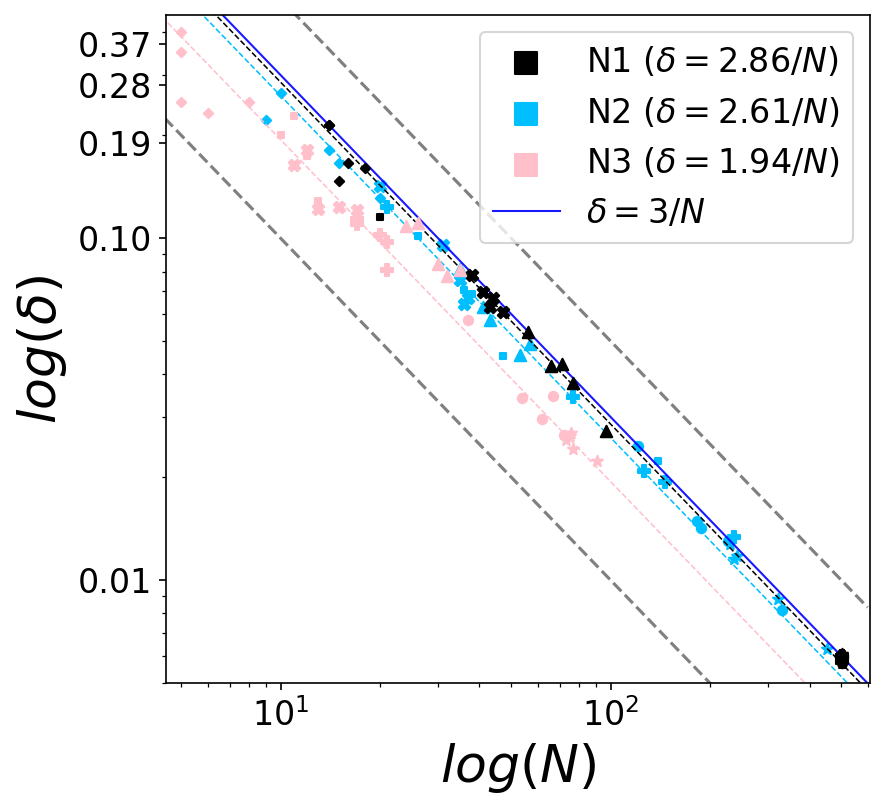

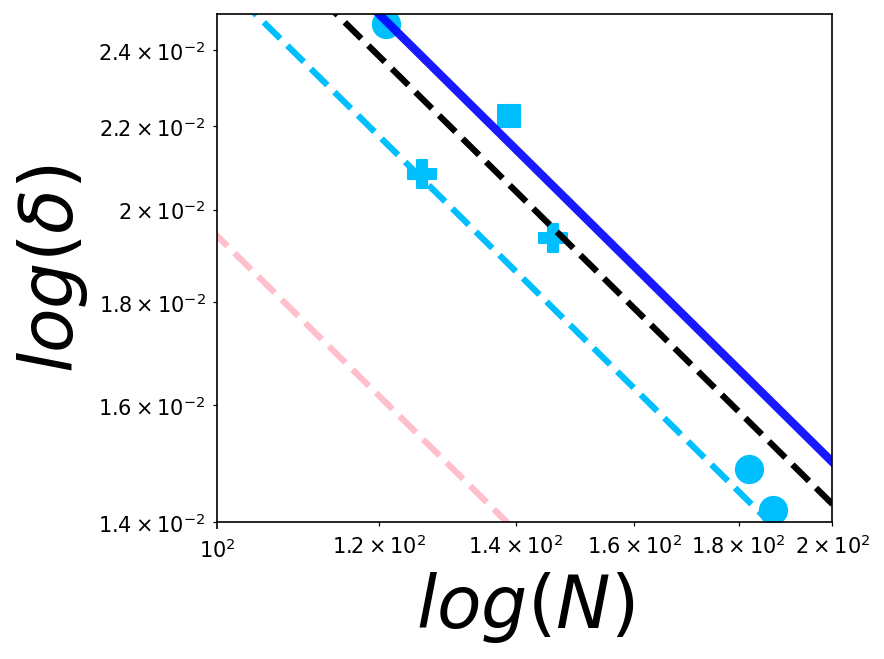

In [43]:
Save= 'No' #'Yes'
Plot_NDensity_3(TaskOrder, NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, NetMsrsN1_NARMA15_Reps, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps, NetMsrsN1_Chaos_Reps, NetMsrsN1_VDP_Reps, \
                NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, NetMsrsN2_NARMA15_Reps, NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps, NetMsrsN2_Chaos_Reps, NetMsrsN2_VDP_Reps, \
                NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps, NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps, \
               NetMsrsV3_Names, AvgDeg_N1, AvgDeg_N2, AvgDeg_N3, Colr, 0,PlotDir,1,Save)

Save= 'No' #'Yes'
Plot_NDensity_3_In(TaskOrder, NetMsrsN1_NARMA5_Reps, NetMsrsN1_NARMA10_Reps, NetMsrsN1_NARMA15_Reps, NetMsrsN1_SinCos1_Reps, NetMsrsN1_SinCos2_Reps, NetMsrsN1_Chaos_Reps, NetMsrsN1_VDP_Reps, \
                NetMsrsN2_NARMA5_Reps, NetMsrsN2_NARMA10_Reps, NetMsrsN2_NARMA15_Reps, NetMsrsN2_SinCos1_Reps, NetMsrsN2_SinCos2_Reps, NetMsrsN2_Chaos_Reps, NetMsrsN2_VDP_Reps, \
                NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps, NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps, \
               NetMsrsV3_Names, AvgDeg_N1, AvgDeg_N2, AvgDeg_N3, Colr, 0,PlotDir,1,Save)

## 2.3. Performance of Evolved networks

In [44]:
def Plot_Score(TaskType, NetMsrsA, NetMsrsB, NetMsrsC, NetMsrsD, NetMsrsE, NetMsrsF, NetMsrsG, ScoresA, ScoresB, ScoresC,\
                ScoresD, ScoresE, ScoresF, ScoresG, Colr, Lima, Limb,PlotDir,Save='No'):
    fig_size = plt.rcParams["figure.figsize"]  
    fig_size[0] = 6; fig_size[1] = 5.5
    plt.rcParams["figure.figsize"] = fig_size  

    fig, ax = plt.subplots(1, 1, dpi=150)
    for r in range(0,NetMsrsA.shape[0],2):
    
        ### Find first 0 location#################
        ZerosLocFirstA = FirstZeroLocFinder(NetMsrsA[r,:,0])
        ZerosLocFirstB = FirstZeroLocFinder(NetMsrsB[r,:,0])
        ZerosLocFirstC = FirstZeroLocFinder(NetMsrsC[r,:,0])
        ZerosLocFirstF = FirstZeroLocFinder(NetMsrsF[r,:,0])
        ZerosLocFirstG = FirstZeroLocFinder(NetMsrsG[r,:,0])
        ##########################################
        i=1
        ax.plot(NetMsrsA[r,:ZerosLocFirstA,0], ScoresA[r,i,:ZerosLocFirstA,0,0], lw=0.5,c=Colr[0],alpha=0.5)
        ax.plot(NetMsrsB[r,:ZerosLocFirstB,0], ScoresB[r,i,:ZerosLocFirstB,0,0], lw=0.5,c=Colr[1],alpha=0.4)
        ax.plot(NetMsrsC[r,:ZerosLocFirstC,0], ScoresC[r,i,:ZerosLocFirstC,0,0], lw=0.5,c=Colr[2],alpha=0.5)
        ax.plot(NetMsrsF[r,:ZerosLocFirstF,0], ScoresF[r,i,:ZerosLocFirstF,0,0], lw=0.5,c=Colr[5],alpha=0.5)
        ax.plot(NetMsrsG[r,:ZerosLocFirstG,0], ScoresG[r,i,:ZerosLocFirstG,0,0], lw=0.5,c=Colr[6],alpha=0.5)

        ax.scatter(NetMsrsA[r,ZerosLocFirstA-1,0], ScoresA[r,i,ZerosLocFirstA-1,0,0],zorder=1, marker='P', s=120, c=Colr[0])
        ax.scatter(NetMsrsB[r,ZerosLocFirstB-1,0], ScoresB[r,i,ZerosLocFirstB-1,0,0],zorder=1, marker='o', s=80, c=Colr[1])
        ax.scatter(NetMsrsC[r,ZerosLocFirstC-1,0], ScoresC[r,i,ZerosLocFirstC-1,0,0],zorder=1, marker='*', s=150, c=Colr[2])
        ax.scatter(NetMsrsF[r,ZerosLocFirstF-1,0], ScoresF[r,i,ZerosLocFirstF-1,0,0],zorder=1, marker='^', s=120, c=Colr[5])
        ax.scatter(NetMsrsG[r,ZerosLocFirstG-1,0], ScoresG[r,i,ZerosLocFirstG-1,0,0],zorder=1, marker='X', s=100, c=Colr[6])

    for r in range(Lima, Limb,2): #(NetMsrsC.shape[0]):
        ### Find first 0 location#################
        ZerosLocFirstD = FirstZeroLocFinder(NetMsrsD[r,:,0])
        ZerosLocFirstE = FirstZeroLocFinder(NetMsrsE[r,:,0])
        ##########################################
        i=1
        ax.plot(NetMsrsD[r,:ZerosLocFirstD,0], ScoresD[r,i,:ZerosLocFirstD,0,0], lw=0.5,c=Colr[3],alpha=0.5)
        ax.plot(NetMsrsE[r,:ZerosLocFirstE,0], ScoresE[r,i,:ZerosLocFirstE,0,0], lw=0.5,c=Colr[4],alpha=0.5)

        ax.scatter(NetMsrsD[r,ZerosLocFirstD-1,0], ScoresD[r,i,ZerosLocFirstD-1,0,0],zorder=1, marker='D', s=80, c=Colr[3])
        ax.scatter(NetMsrsE[r,ZerosLocFirstE-1,0], ScoresE[r,i,ZerosLocFirstE-1,0,0],zorder=1, marker='s', s=80, c=Colr[4])

        ax.set_xlabel('Nodes', fontsize=25)
        ax.set_ylabel('NMSE Predict', fontsize=25)
        ax.tick_params(axis='both',labelsize=20)
        ax.set_ylim(-0.03,1.01)
        ax.set_xscale('log')
        # ax.set_yscale('log')
        ax.set_xlim(1.9,100)
    
    fig.tight_layout()
    if Save=='Yes':
        plt.savefig(os.path.join(PlotDir,'Fig2_b.svg'), bbox_inches='tight')
    plt.show()

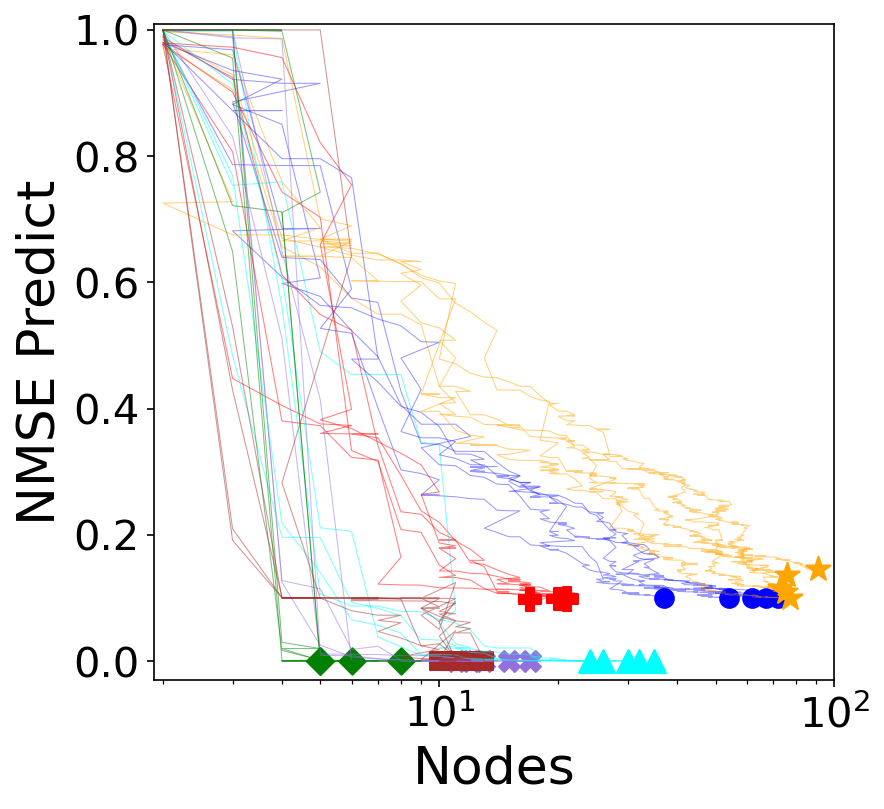

In [45]:
Save='No'#'Yes'

Plot_Score(TaskOrder, NetMsrsN3_NARMA5_Reps, NetMsrsN3_NARMA10_Reps, NetMsrsN3_NARMA15_Reps, NetMsrsN3_SinCos1_Reps, NetMsrsN3_SinCos2_Reps, \
            NetMsrsN3_Chaos_Reps, NetMsrsN3_VDP_Reps, ScoresN3_NARMA5_Reps, ScoresN3_NARMA10_Reps, ScoresN3_NARMA15_Reps, ScoresN3_SinCos1_Reps, \
            ScoresN3_SinCos2_Reps, ScoresN3_Chaos_Reps, ScoresN3_VDP_Reps, Colr,0,10,PlotDir,Save)
